# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель работы**

Построить модель, оценивающую рыночную стоимость автомобиля на основе данных о технических характеристиках, комплектации и ценах других автомобилей.

**Ход работы**
1. Выполнить первоначальный обзор данных;
2. Выполнить предобработку данных при необходимости;
3. Выполнить исследовательский анализ;
4. Подобрать наиболее оптимальную модель, опираясь на критерии заказчика;
5. Протестировать модель;
6. Проанализировать и сделать выводы о времени обучения, предсказания и качестве моделей;
7. Сделать выводы по эффективности построенной модели и предоставить бизнесу рекомендации.

Также, следует учитывать следующие ***условия***:

- На этапе обучения и настройки моделей проверить как минимум одну модель **LightGBM** и как минимум одну модель, не являющуюся моделью бустинга;
- Для оценки качества моделей использовать метрику **RMSE**;
- Значение метрики RMSE должно быть **меньше 2500**;
- При настройке модели подбирать **не более 3 гиперпараметров**;
- **Критерии выбора** лучшей модели:
    - качество предсказания;
    - время обучения модели;
    - время предсказания модели.


## Обзор данных

### Импорт библиотек и функций

Перед непосредственным обзором данных выполним установку и импорт необходимых библиотек и функций, которые потребуются в дальнейшей работе:

In [5]:
# Установка необходимых библиотек
!pip install pandasql
!pip install optuna
!pip install missingno

In [169]:
# Импорт из стандартной библиотеки
import time
import re

# Импорт из сторонних библиотек
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pandasql import sqldf

Комментарии к используемым библиотекам и функциям:
- **pandas**: Используется на протяжении всего проекта для работы с данными;
- **matplotlib.pyplot**, **seaborn** и **missingno**: Используются для создания графиков и диаграмм;
- **Модули sklearn**: Применяются для задач машинного обучения (модель "Случайного леса", метрика RMSE, разделение выборки, перебор гиперпараметров, пайплайн и т.д);
- **lightgbm**: Модель LightGBM градиентного бустинга для задач машинного обучения;
- **optuna**: В проекте используется для оптимизации подбора гиперпараметров совместно с LightGBM;
- **numpy**: Библиотека для работы с числовыми данными;
- **time**: В проекте используется для контроля времени выполнения обучения и предсказания;
- **pandasql**: Используется для формирования выборок данных по сложным условиям с помощью SQL.

### Обзор датасета

Нам предоставлен датасет `/datasets/autos.csv` с данными об автомобилях.

Содержание исходного датасета:


**Признаки**:
- ***DateCrawled*** — дата скачивания анкеты из базы;
- ***VehicleType*** — тип автомобильного кузова;
- ***RegistrationYear*** — год регистрации автомобиля;
- ***Gearbox*** — тип коробки передач;
- ***Power*** — мощность (л. с.);
- ***Model*** — модель автомобиля;
- ***Kilometer*** — пробег (км);
- ***RegistrationMonth*** — месяц регистрации автомобиля;
- ***FuelType*** — тип топлива;
- ***Brand*** — марка автомобиля;
- ***Repaired*** — была машина в ремонте или нет;
- ***DateCreated*** — дата создания анкеты;
- ***NumberOfPictures*** — количество фотографий автомобиля;
- ***PostalCode*** — почтовый индекс владельца анкеты (пользователя);
- ***LastSeen*** — дата последней активности пользователя.

**Целевой признак**
- ***Price*** — цена (евро).

Сохраним датасет в переменную `df` и выведем основную информацию о ней:

In [7]:
df = pd.read_csv('/datasets/autos.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Также, выведем часть датасета на экран, чтобы визуально оценить данные:

In [8]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3287,2016-03-16 20:58:18,7900,sedan,2009,manual,102,golf,100000,10,petrol,volkswagen,no,2016-03-16 00:00:00,0,58644,2016-03-17 20:21:25
323736,2016-03-17 14:52:09,2500,convertible,2001,manual,147,astra,150000,6,petrol,opel,no,2016-03-17 00:00:00,0,52531,2016-04-06 21:17:48
190593,2016-03-26 16:56:09,8299,wagon,2006,manual,170,passat,150000,10,NaN,volkswagen,no,2016-03-26 00:00:00,0,81241,2016-04-06 05:44:29
20024,2016-03-19 10:49:30,14900,bus,2014,manual,120,zafira,40000,1,petrol,opel,no,2016-03-19 00:00:00,0,32657,2016-04-06 11:17:25
173146,2016-03-09 17:58:28,690,NaN,2017,manual,60,lupo,125000,6,NaN,volkswagen,yes,2016-03-09 00:00:00,0,45357,2016-03-10 03:45:43
339693,2016-04-04 00:55:56,17499,wagon,2011,auto,140,passat,80000,2,gasoline,volkswagen,no,2016-04-04 00:00:00,0,6242,2016-04-06 09:16:48
316780,2016-04-02 20:51:35,850,wagon,2005,manual,116,mondeo,150000,8,gasoline,ford,no,2016-04-02 00:00:00,0,24143,2016-04-06 21:44:34
222729,2016-03-08 10:47:41,9500,wagon,2011,manual,109,other,90000,6,lpg,hyundai,no,2016-03-08 00:00:00,0,45143,2016-04-07 04:15:21
193445,2016-03-16 21:48:26,450,small,1998,manual,37,fiesta,60000,11,petrol,ford,no,2016-03-16 00:00:00,0,27576,2016-03-16 21:48:26
214784,2016-03-27 18:51:28,200,sedan,1997,manual,102,3er,150000,0,NaN,bmw,yes,2016-03-27 00:00:00,0,14478,2016-03-27 18:51:28


Так как в датасете часть признаков имеет пропуски, отдельно выделим столбцы, где они присутствуют, и в каком проценте от общего количества записей:

In [9]:
# Создание DataFrame с информацией о проценте и количестве пропущенных значений
missing_data_info = pd.DataFrame({
    'nan_percent': round(df.isna().mean() * 100),
    'nan_count': df.isna().sum()
})

# Фильтрация столбцов, где количество пропущенных значений не равно нулю
missing_data_info = missing_data_info[missing_data_info['nan_count'] != 0]

# Сброс индекса для преобразования индекса в столбец
missing_data_info = missing_data_info.reset_index()

# Переименование столбца индекса в 'column_name'
missing_data_info.rename(columns={'index': 'column_name'}, inplace=True)

# Сортировка по убыванию процента пропущенных значений
missing_data_info.sort_values(by='nan_percent', ascending=False, inplace=True)

# Применение стилизации к DataFrame для визуализации
styled_missing_data_info = missing_data_info.style.background_gradient('coolwarm')

# Отобразим DataFrame с долей пропущенных значений
styled_missing_data_info

,column_name,nan_percent,nan_count
4,Repaired,20.000000,71154
0,VehicleType,11.000000,37490
3,FuelType,9.000000,32895
1,Gearbox,6.000000,19833
2,Model,6.000000,19705


Можем, также, визуализировать распределение пропусков с помощью библиотеки ***missingno***:

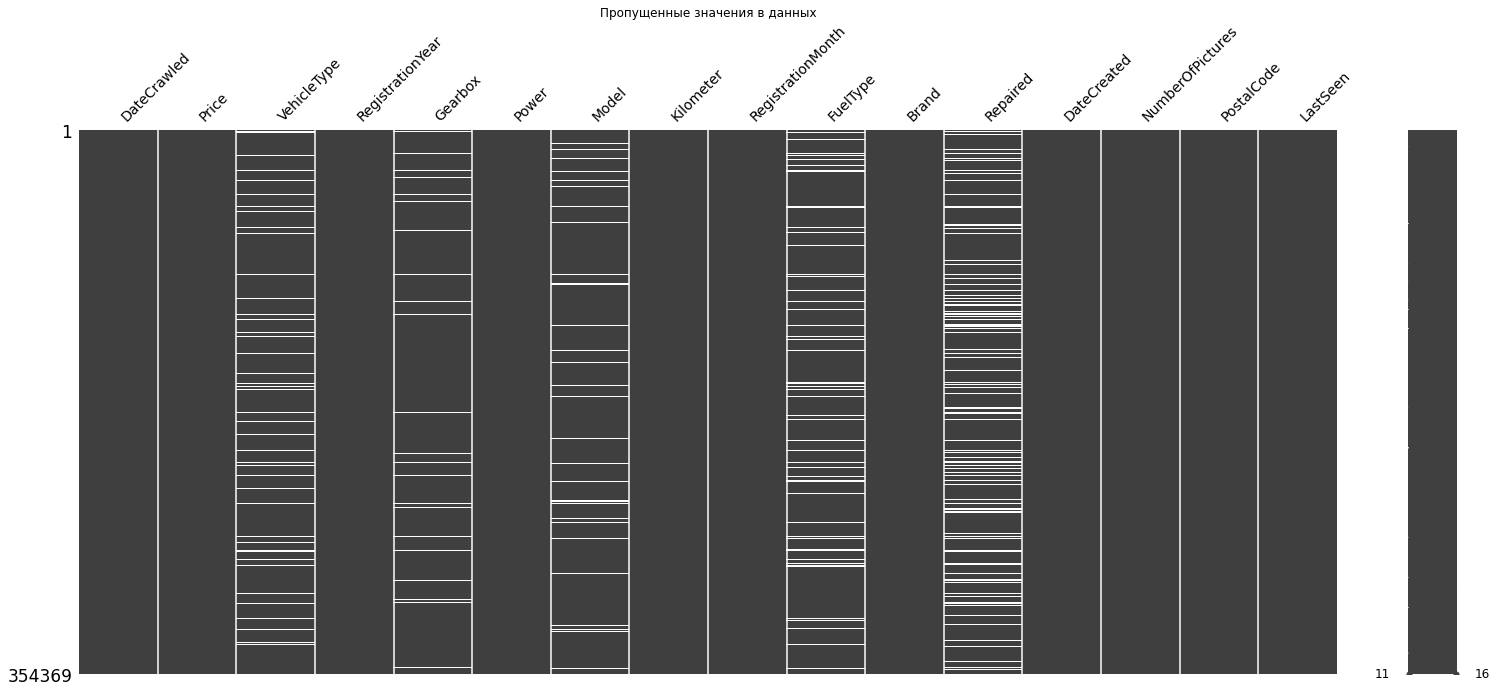

In [10]:
msno.matrix(df, fontsize=14)
plt.title('Пропущенные значения в данных')
plt.show()

Теперь проверим датасет на наличие полных дублей:

In [11]:
print('Всего полных дублей:', df.duplicated().sum())

Всего полных дублей: 4


Выведем также гистограммы числовых признаков:

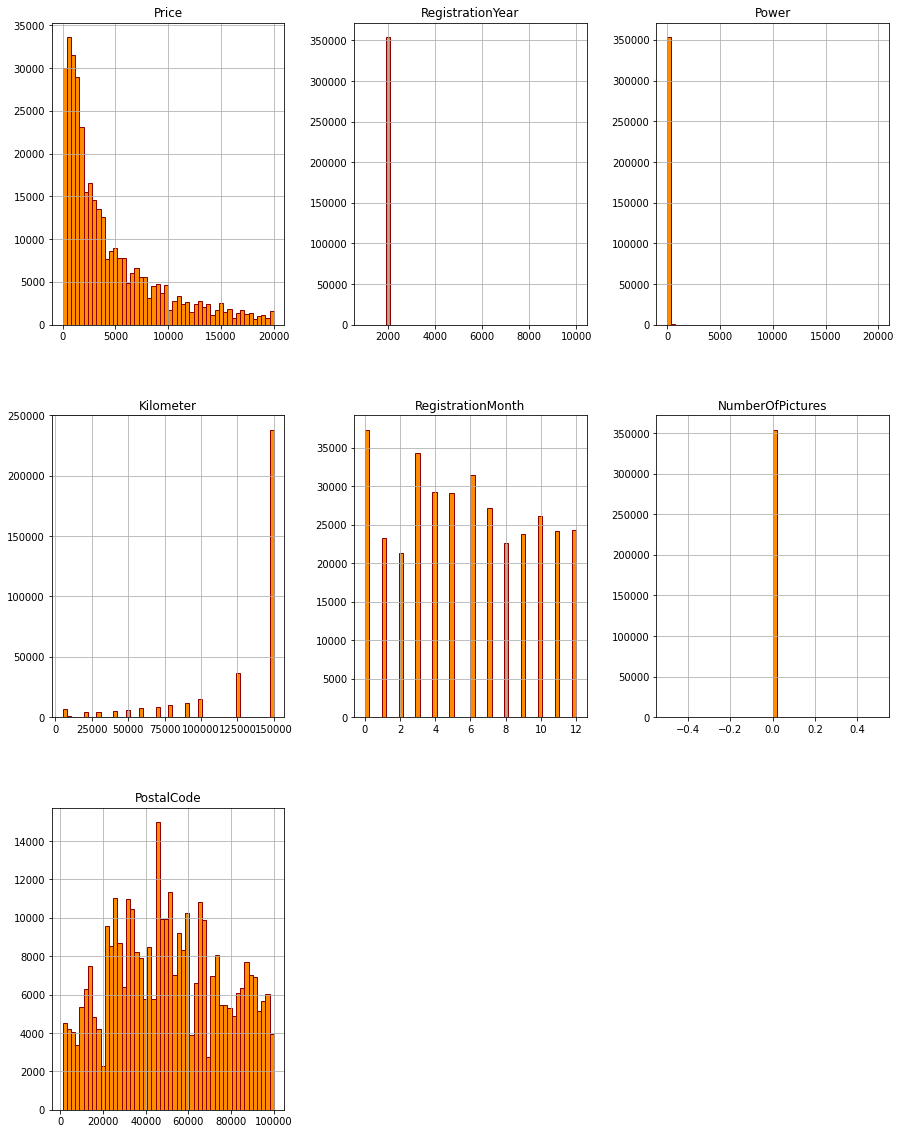

In [12]:
df.hist(bins=50, figsize=(15, 20), color='darkorange', ec='darkred')
plt.show()

#### Вывод

По данным выше можем выделить следующие наблюдения:

- Так как целевым признаком является цена, то перед нами задача **регрессии**;
- Всего **15 признаков**, не считая целевой признак, который должна будет предсказать модель;
- Общее количество записей в исходной таблице — **354 369**;
- В датасете присутствуют как категориальные, так и количественные признаки;
- Следующие столбцы имеют пропуски от 6 до 20 процентов от общего количества строк:
    - *VehicleType*: **12%** пропусков;
    - *Gearbox*: **6%** пропусков;
    - *Model*: **6%** пропусков;
    - *FuelType*: **10%** пропусков;
    - *Repaired*: **20%** пропусков.
- В датафрейме присутствует **4 полных дубля**;
- Часть признаков может не представлять ценности для анализа и обучения модели;
- Названия столбцов представлены в стиле "CamelCase";
- Признаки `Power` и `RegistrationYear`, похоже, имеют аномально большие выбросы в небольших количествах.

Основываясь на этой информации, мы можем приступить к этапу *предобработки данных*, имея общее представление о структуре данных и некоторых их особенностях.

## Предобработка данных

### Переименование столбцов

Хоть непосредственно для Pandas и не существует общепринятого станарта вроде *PEP8*, всё же переименуем столбцы для соблюдения единообразия и стандарта там, где это возможно.

Кроме того, некоторые столбцы можно переименовать для более однозначного и понятного понимания содержимого этих столбцов.

- ***date_crawled*** ← DateCrawled
- ***vehicle_type*** ← VehicleType
- ***registration_year*** ← RegistrationYear
- ***gearbox_type*** ← Gearbox *(делаем акцент на том, что это тип двигателя, по аналогии с vehicle_type и fuel_type)*
- ***power*** ← Power
- ***model*** ← Model
- ***driven_km*** ← Kilometer *(более явно указываем на то, что это пробег. "Километр" - не слишком информативно)*
- ***registration_month*** ← RegistrationMonth
- ***fuel_type*** ← FuelType
- ***brand*** ← Brand
- ***repaired*** ← Repaired *(можно было бы переименовать в "is_repaired", но в столбце есть пропуски, которые могут несути в себе смысл "неизвестно")*
- ***date_created*** ← DateCreated
- ***pictures_count*** ← NumberOfPictures *(приведём к более лаконичному варианту)*
- ***postal_code*** ← PostalCode
- ***last_activity*** ← LastSeen
- ***price*** ← Price

Выполним переименование:

In [13]:
df = df.rename(columns={'DateCrawled': 'date_crawled',
                        'VehicleType': 'vehicle_type',
                        'RegistrationYear': 'registration_year',
                        'Gearbox': 'gearbox_type',
                        'Power': 'power',
                        'Model': 'model',
                        'Kilometer': 'driven_km',
                        'RegistrationMonth': 'registration_month',
                        'FuelType': 'fuel_type',
                        'Brand': 'brand',
                        'Repaired': 'repaired',
                        'DateCreated': 'date_created',
                        'NumberOfPictures': 'pictures_count',
                        'PostalCode': 'postal_code',
                        'LastSeen': 'last_activity',
                        'Price': 'price'})

pd.Series(df.columns)

0           date_crawled
1                  price
2           vehicle_type
3      registration_year
4           gearbox_type
5                  power
6                  model
7              driven_km
8     registration_month
9              fuel_type
10                 brand
11              repaired
12          date_created
13        pictures_count
14           postal_code
15         last_activity
dtype: object

Столбцы успешно переименованы. Далее будем работать именно с этими именами.

### Анализ на наличие лишних признаков

Из датасета следует удалить те признаки, которые не несут в себе полезной для задачи проекта информации. То есть, это всё, что не касается напрямую характеристик автомобиля.

Проанализируем следующие наиболее неоднозначные столбцы и примем решение:
- ***date_crawled*** — дата скачивания анкеты из базы;
- ***registration_year*** — год регистрации автомобиля;
- ***registration_month*** — месяц регистрации автомобиля;
- ***date_created*** — дата создания анкеты;
- ***pictures_count*** — количество фотографий автомобиля;
- ***postal_code*** — почтовый индекс владельца анкеты (пользователя);
- ***last_activity*** — дата последней активности пользователя.

#### Столбец "date_crawled"

Информация о дате скачивания анкеты не является полезной, потому что никак не отражает ценность автомобиля.

***Итог***: удалим признак.

***Причина***: отсутствие полезной информации.

#### Столбцы "registration_month" и "registration_year"

Месяц выпуска автомобиля вероятнее всего играет менее существенную роль, чем год выпуска (будем считать, что дата регистрации ≈ дата производства).

Тем не менее, если скомбинировать признаки "registration_year" и "registration_month" в один, то можно было бы посчитать возраст автомобиля (с некоторым округлением), что может играть важную роль в ценообразовании.
Возраст автомобиля можно посчитать, если вычтем дату выпуска автомобиля из даты создания анкеты.

Единственный нюанс - анкета может быть открыта длительное время, из-за чего актуальная рыночная стоимость может отличаться от той, что была спрогнозирована при заведении анкеты. В условиях задачи к проекту не уточняется, в какой момент пользователю приложения должна быть предоставлена оценка цены автомобиля: только <u>при первоначальном вводе данных</u> или же должна отражаться в относительно <u>реальном времени</u>.

На текущий момент вероятнее всего пойдём по первому пути и будем оценивать возраст автомобиля от даты его регистрации до даты создания анкеты.

Проверим, за какие года создания анкеты присутствуют данные:

In [14]:
df['registration_year'].value_counts()

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 151, dtype: int64

In [15]:
df['registration_year'].nunique()

151

Уже здесь видно, что в датасете есть некорректные года, на что мы ранее обратили внимание по гистограмме из п. 1.2.



***Итог***: 
В датасете 151 уникальный год, часть из которых явно записаны **некорректно**. Приведём этот столбец в порядок в дальнейшей части работы.
Также, далее мы создадим новый признак с возрастом автомобиля (перед этим исправим содержимое столбца с годом регистрации).
Столбец `registration_month` будет удалён. А судьба столбца `registration_year` решится, когда посмотрим на корреляции между признаками.

#### Столбец "date_created"

Сама по себе дата создания анкеты не несёт в себе полезной информации об автомобиле, но в связке с датой регистрации автомобиля можно посчитать возраст автомобиля, как уже было сказано в п. 2.2.2.

***Итог***: на основе этого столбца (и столбца с годом регистрации автомобиля) будет создан признак с возрастом автомобиля. После чего текущий столбец будет удалён.

#### Столбец "pictures_count"

Хоть фотографии в некотором смысле и описывают автомобиль, но не являются на 100% объективной характеристикой для него. Тем более, учитывая, что сервис не сможет учитывать внешний вид автомобиля (по крайней мере, без использования продвинутых нейросетей) как конкретную характеристику для расчёта цены.

При этом сам факт наличия фотографий или отсутствия, вероятно, может влиять на цену в анкете.

В целом признак получается спорным, поэтому дополнительно посмотрим на его данные:

In [16]:
df['pictures_count'].value_counts()

0    354369
Name: pictures_count, dtype: int64

Оказалось, что все объекты данного датасета имеют значение "0" по признаку количества фотографий.
Вероятно, что это какая-то ошибка в данных или иная проблема с сервисом, но в любом случае это окончательно убеждает нас в том, что данный признак не принесёт пользы при обучении модели.

***Итог***: удалим признак.

***Причина***: полное отсутствие информации.

#### Столбец "postal_code"

Сам по себе признак `postal_code` не несёт полезной информации, так как указывает на конкретный почтовый индекс, коих может быть большое множество на один город/регион. Зато если бы мы знали, к какому городу относится тот или иной `postal_code`, то могли бы использовать этот признак в нашей задаче, так как для разных городов цены уже действительно могут отличаться. 

Поэтому перед тем как удалять этот признак, на его основе мы создадим новый признак. Далее, в п. 2.3.2 мы определим, к какой стране или странам относится данный датасет, найдём в Интернете датасет с информацией о почтовых индексов для различных регионов, предобработаем его до необходимой степени и выполним создание нового столбца.

***Итог***: создадим новый признак на основе `postal_code` и отдельного датасета, текущий признак удалим.

#### Столбец "last_activity"

Как и столбец `date_crawled` и `date_created`, не несёт в себе сам по себе полезной информации. Единственное, что мы сейчас проверим - это последние даты в этом столбце и сравним с датами `date_created`, чтобы понимать, "в каком году мы находимся" в этом датасете.

(столбцы представлены в строковом типе, а не в типе дат, но сейчас нам это не помешает вывести минимальное и максимальное значения)

In [17]:
print('Максимальная дата активности пользователя:', df['last_activity'].max())
print('Минимальная дата создания анкеты:', df['date_created'].min())

Максимальная дата активности пользователя: 2016-04-07 14:58:51
Минимальная дата создания анкеты: 2014-03-10 00:00:00


Выходит, что датасет представлен за два года и сформирован со срезом с 03.2014 по 04.2016.
Для расчёта столбца с возрастом автомобиля, который возможность создания которого рассматривалась в п. 2.2.2., у нас есть два варианта:
- Использовать дату **2016-04-07** как верхнюю границу даты, от которой будет идти точка отсчёта до даты регистрации автомобиля;
- Использовать дату создания анкеты `date_created` каждого конкретного объекта, считая, что цена автомобиля прогнозируется автоматически только в момент создания анкеты.

Данных о состоянии анкеты у нас нет, поэтому мы не можем знать, продан автомобиль или нет, что также затрудняет решение.
Но тем не менее, задача предполагает, что основной функционал приложения - это вывод цены для пользователя именно в момент создания заявки. Кроме того, отсчитывая возраст от `date_created` мы дополнительно узнаем, машины какого возраста в наибольшей/наименьшей степени выставляются на продажу, что может быть полезным на этапе формирования рекомендаций для Бизнеса.

***Итог***: удалим признак.

***Причина***: отсутствие полезной информации.

#### Удаление части признаков

Часть признаков потребуется нам для создания новых на основе исходных. По этой причине на текущем этапе удалим лишь часть признаков, которые не пригодятся нам вовсе:

- **date_crawled**;
- **pictures_count**;
- **last_activity**.

In [18]:
try:
    df = df.drop(columns=['date_crawled', 'pictures_count', 'last_activity'])
    print('Столбцы удалены')
except:
    print('Столбцы уже удалены')

pd.Series(['date_crawled', 'pictures_count', 'last_activity']).isin(df.columns)

Столбцы удалены


0    False
1    False
2    False
dtype: bool

### Анализ и исправление аномалий в данных

Проверим столбцы датасета на наличие аномалий. При необходимости исправим их.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        316879 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox_type        334536 non-null  object
 4   power               354369 non-null  int64 
 5   model               334664 non-null  object
 6   driven_km           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           321474 non-null  object
 9   brand               354369 non-null  object
 10  repaired            283215 non-null  object
 11  date_created        354369 non-null  object
 12  postal_code         354369 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 35.1+ MB


#### Столбец "price"

Построим гистограмму отдельно по столбцу "price":

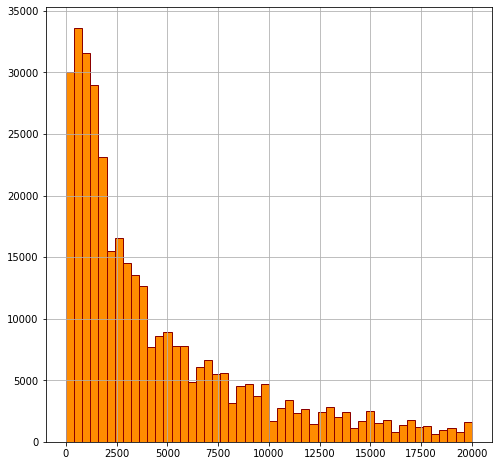

In [20]:
df['price'].hist(bins=50, figsize=(8, 8), color='darkorange', ec='darkred')
plt.show()

Проверим числовое описание столбца:

In [21]:
df['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Гистограмма в целом не вызывает вопросов, но по числовому описанию данных видно, что есть автомобили, для которых указана цена - 0. Посмотрим, сколько всего таких автомобилей в датасете.

In [22]:
df[df['price'] == 0]['price'].count()

10772

Проверим также, есть ли автомобили с NaN-ценой:

In [23]:
df['price'].isna().sum()

0

Автомобилей с NaN-ценой нет.

И также определим долю "бесплатных" автомобилей относительно всего датасета:

In [24]:
round((df[df['price'] == 0]['price'].count() / df['price'].count() * 100), 2)

3.04

Всего в датасете имеется 10772 автомобилей с нулевой ценой или **3,04%** от общего количества.

Возможные варианты действий следующие:
- Удалить строки с нулевой ценой;
- Заменить значение цены на медианное/среднее значение по каждому бренду.

В данном случае выберем первый вариант. Замена цены на среднее значение по бренду могла бы стать близкой к реальной цене, но это всё равно будет некоторым искажением данных. А учитывая, что это целевой признак, выполнять подобные преобразования кажется не самым "безопасным" шагом.

Выполним удаление строк с нулевой ценой.

In [25]:
df = df[~(df['price'] == 0)]

df

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,26624
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,39576
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439


Проверим, что строк с нулевой ценой не осталось.

In [26]:
df[(df['price'] == 0)]

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code


Убедимся, что остальные значения цен не изменились, сформировав гистограмму.

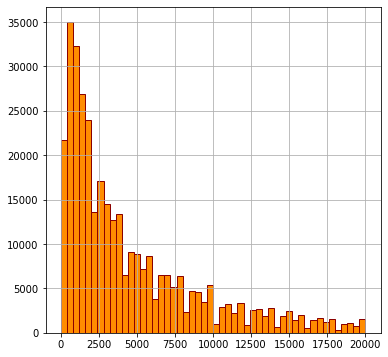

In [27]:
df['price'].hist(bins=50, figsize=(6, 6), color='darkorange', ec='darkred')
plt.show()

Посмотрим снова на числовое распределение столбца.

In [28]:
df['price'].describe()

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Теперь видим, что минимальная цена автомобиля - 1 евро. Что тоже вызывает определённые вопросы. Посмотрим на эти записи.

In [29]:
df[df['price'] == 1]

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,53721
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,40589
268,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11 00:00:00,55122
408,1,NaN,2000,NaN,75,golf,90000,3,petrol,volkswagen,NaN,2016-03-29 00:00:00,78588
901,1,NaN,1990,manual,0,other,150000,0,NaN,porsche,NaN,2016-03-05 00:00:00,65843
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353252,1,coupe,1990,manual,45,polo,150000,0,petrol,volkswagen,no,2016-03-09 00:00:00,26160
353584,1,NaN,2000,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-31 00:00:00,52525
353682,1,bus,1999,manual,0,espace,150000,0,petrol,renault,NaN,2016-03-07 00:00:00,57439
353727,1,NaN,2000,NaN,0,NaN,150000,0,NaN,bmw,NaN,2016-03-20 00:00:00,42329


Как видно, имеется существенное число записей с ценой в 1 евро. Посмотрим, сколько подобных автомобилей с ценой до 200 евро (что всё равно является далеко от правдоподобной цены на автомобиль).

In [30]:
df[df['price'] <= 200].sample(20)

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code
40062,200,small,1999,manual,43,twingo,150000,3,petrol,renault,yes,2016-03-16 00:00:00,25421
292238,11,wagon,1997,manual,150,a4,150000,3,petrol,audi,no,2016-03-21 00:00:00,85290
320900,200,convertible,1993,manual,90,golf,150000,12,NaN,volkswagen,yes,2016-03-05 00:00:00,56581
165530,200,small,1997,manual,68,justy,125000,1,petrol,subaru,yes,2016-03-30 00:00:00,94262
112430,200,small,2002,manual,50,ka,150000,0,petrol,ford,NaN,2016-03-08 00:00:00,65719
221938,1,bus,1994,manual,88,other,150000,0,gasoline,volkswagen,no,2016-03-21 00:00:00,1796
249951,150,small,1996,manual,0,corsa,150000,9,petrol,opel,NaN,2016-03-14 00:00:00,26624
43262,120,small,1997,manual,0,NaN,150000,0,NaN,renault,NaN,2016-04-01 00:00:00,44319
103855,200,small,1994,manual,48,polo,5000,0,gasoline,volkswagen,yes,2016-03-06 00:00:00,25712
47764,120,small,1998,manual,0,other,150000,0,petrol,citroen,NaN,2016-04-04 00:00:00,15910


Уже имеем 200 записей. Особенно примечательно, что среди них есть и записи относительно новых автомобилей.
Учитывая, что границу "адекватности" цены определить достаточно сложно, а при приближении к ней записей становится только больше, кажется достаточно сложным решить, как поступать с такими записями.

Пока предлагается оставить их без изменений, а при обучении модели машинного обучения дополнительно обработать, если результаты предсказаний будут иметь низкое качество.

**Итог**:

Столбец "price" обработан, от нулевых значений цены избавились удалением записей с нулевой ценой.
Подозрительно низкие цены на текущий момент решено не обрабатывать в силу риска потерять существенный объём данных и сложности предобработки в целом.

#### Столбец "brand"

Рассмотрим признак "brand". В первую очередь посмотрим на уникальные значения брендов:

In [31]:
df['brand'].value_counts()

volkswagen        74413
opel              38530
bmw               35809
mercedes_benz     31359
audi              28574
ford              24457
renault           17389
peugeot           10781
fiat               9332
seat               6718
mazda              5465
skoda              5435
smart              5171
citroen            5029
nissan             4807
toyota             4536
hyundai            3533
mini               3165
volvo              3122
mitsubishi         2927
sonstige_autos     2847
honda              2715
kia                2407
suzuki             2273
alfa_romeo         2234
chevrolet          1704
chrysler           1368
dacia               890
daihatsu            775
subaru              735
porsche             734
jeep                658
land_rover          534
daewoo              533
saab                515
trabant             498
jaguar              493
rover               462
lancia              457
lada                213
Name: brand, dtype: int64

Как видно, всего несколько брендов автомобилей ярко выраженно распространены в датасете. Больше половины брендов имеют достаточное малое количество строк на фоне всего датасета в целом.

Проверим также признак на пропуски:

In [32]:
df['brand'].isna().sum()

0

Пропусков по данному признаку нет.

Судя по полученному результату `value_counts()`, чёткой границы между распространёнными и менее распространёнными брендами автомобилей нет. Для того, чтобы не определять эту границу "на глаз", воспользуемся методом "локтя" для определения точки, на которой заканчивается резкий спад частоты брендов автомобилей и начинается более плавное. Это и станет точкой, определяющей начало группы "редко" встречающихся брендов автомобилей.

Оптимальный порог методом "локтя" будет реализован следующими этапами:

1. Определение координат первой и последней точки на графике частот;
2. Для каждой точки на графике вычисляется перпендикулярное расстояние до линии (назовём её **AB**), соединяющей первую и последние точки;
3. Находим точку с максимальным расстоянием до линии - это и будет считаться точкой "локтя".

In [33]:
def elbow_finder(p_feature):
    # Распределение количества значений в признаке
    feature_counts = df[p_feature].value_counts()
    
    # Координаты первой и последней точки
    x1, y1 = 0, feature_counts.values[0]
    x2, y2 = len(feature_counts) - 1, feature_counts.values[-1]
    
    # Координаты всех точек
    x_coords = np.arange(len(feature_counts))
    y_coords = feature_counts.values
    
    # Находим коэффициенты A, B и C
    coeff_a = y2 - y1
    coeff_b = x2 - x1
    coeff_c = x2 * y1 - y2 * x1
    
    # Считаем формулу прямой, проходящей через точки (x1, y1) и (x2, y2)
    line_ab = coeff_a * x_coords - coeff_b * y_coords + coeff_c

    # Расчет перпендикулярных расстояний от точек до линии (x1, y1) -> (x2, y2)
    distances = np.abs(line_ab) / np.sqrt(coeff_a ** 2 + coeff_b ** 2)
    
    # Нахождение индекса точки с максимальным расстоянием
    elbow_index = np.argmax(distances)

    # Визуализация для проверки точки "локтя"
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts.values, label="Частоты")
    plt.scatter(elbow_index, feature_counts.values[elbow_index], color='red', label="Локоть")
    plt.title('Определение "локтя" в распределении частот по признаку')
    plt.xlabel('Индекс')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Вывод индекса "локтя" и соответствующего значения частоты
    display(elbow_index, feature_counts.values[elbow_index])

x1, и y1 задают координаты первой точки на графике. Поскольку модели уже отсортированы по убыванию частоты (за счёт `value_counts()`), x1 равен ***0*** (первый индекс в отсортированном массиве), а y1 — это частота самой распространенной модели (***model_counts.values[0]***).

x2 и y2 задают координаты последней точки. x2 — это индекс последней модели в отсортированном списке (***len(model_counts) - 1***), а y2 — частота наименее распространенной модели (***model_counts.values[-1]***).

Далее определяются перпендикулярные расстояния от линии **AB** до каждой из точек графика.

Для этого требуется две формулы:
1. Формула уровнения прямой, проходящая через две точки: (x1, y1) и (x2, y2): 
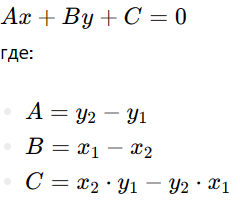


2. Формула для расчёта расстояния от точки на графике до прямой
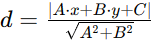


После этого определяем с помощью функции `argmax` максимальное значение массива значений "distances", рисуем график и отображаем точку локтя.

Вызовем функцию `elbow_finder()`, передав на вход признак "brand".

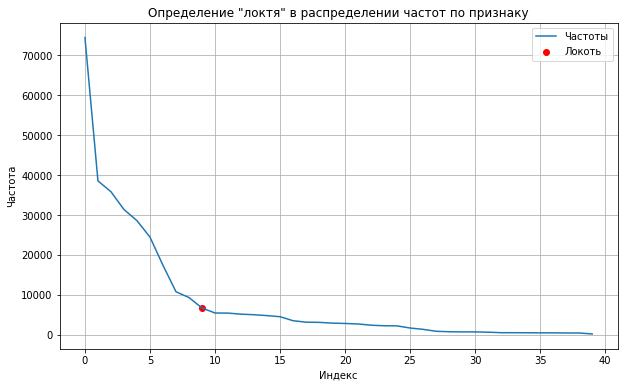

9

6718

In [34]:
elbow_finder('brand')

По результату этого графика с точкой "локтя" можем принять за условную границу, отделяющую редкие и распространённые бренды, точку с индексом 9. Т.е. всё, что встречается 6718 раз и реже, считаем редкими брендами.

Для начала получим список редких брендов.

In [35]:
# Получение списка редких брендов, начиная с индекса 9
rare_brands = df['brand'].value_counts().iloc[9:].index.tolist()

rare_brands

['seat',
 'mazda',
 'skoda',
 'smart',
 'citroen',
 'nissan',
 'toyota',
 'hyundai',
 'mini',
 'volvo',
 'mitsubishi',
 'sonstige_autos',
 'honda',
 'kia',
 'suzuki',
 'alfa_romeo',
 'chevrolet',
 'chrysler',
 'dacia',
 'daihatsu',
 'subaru',
 'porsche',
 'jeep',
 'land_rover',
 'daewoo',
 'saab',
 'trabant',
 'jaguar',
 'rover',
 'lancia',
 'lada']

Теперь используем метод "apply" в сочетании с функцией "transform_brand", чтобы обновить значения моделей на нужные нам.

In [36]:
# Функция для преобразования модели
def transform_brand(row):
    if row['brand'] in rare_brands or row['brand'] == 'other':
        return 'other'
    else:
        return row['brand']

In [37]:
# Применение функции к DataFrame
df['brand'] = df.apply(transform_brand, axis=1)

In [38]:
# Проверка результата
new_brand_counts = df['brand'].value_counts()

new_brand_counts

volkswagen       74413
other            72953
opel             38530
bmw              35809
mercedes_benz    31359
audi             28574
ford             24457
renault          17389
peugeot          10781
fiat              9332
Name: brand, dtype: int64

**Итог**:

Столбец с брендами успешно преобразован. Слишком малочисленные категории преобразованы в одну общую "other".

#### Столбец "model"

Как мы узнали из п.1.2., столбец `model` содержит 19 705 пропусков или 6% строк от всего датасета.
Выведем число пропусков ещё раз:

In [39]:
df[df['model'].isna()]

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954
59,1,suv,1994,manual,286,NaN,150000,11,NaN,other,NaN,2016-03-29 00:00:00,53721
81,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,45665
135,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,38709
151,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27 00:00:00,89077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354245,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07 00:00:00,55743
354321,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,other,yes,2016-03-15 00:00:00,91186
354338,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,41470
354351,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,87700


In [40]:
df['model'].isna().sum()

17521

После удалений записей из п. 2.3.1 осталось 17521 запись с пропущенным значением модели.

Посмотрим, какие есть типы моделей, и нет ли среди них дублей.

In [41]:
np.sort(df['model'].dropna().unique())

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Из данного списка можно увидеть, что "неявными" дублями здесь являются значения "rangerover" и "range_rover". 

Остальные значения сложно выделить как неявные дубли, даже если таковые присутствуют. Мы можем допустим, что они есть из-за разных вариантов написаний одних и тех же моделей, но для данного разбора потребуется глубокий анализ всех представленных моделей, что для данной работы излишне.

Помимо выделенных неявных дублей можем также проверить наиболее редко встречающиеся модели. Если обнаружим модели, которые встречаются критически редко относительно общего числа автомобилей в датасете, то можем объединить их в категорию "other" (которая уже существует).

In [42]:
# Увеличиваем максимально выводимое число строк для возможности анализа
pd.set_option('display.max_rows',250)

model_counts = df['model'].value_counts()

model_counts

golf                  28246
other                 23707
3er                   19179
polo                  12628
corsa                 12197
astra                 10475
passat                 9835
a4                     9642
c_klasse               8174
5er                    7665
e_klasse               6631
a3                     6026
focus                  5750
fiesta                 5656
a6                     5368
twingo                 4817
2_reihe                4763
transporter            4687
fortwo                 4296
a_klasse               4133
vectra                 4094
1er                    3497
mondeo                 3487
clio                   3459
touran                 3428
3_reihe                3425
punto                  3241
zafira                 2994
megane                 2802
ibiza                  2640
ka                     2612
lupo                   2537
octavia                2092
fabia                  2060
cooper                 1934
clk                 

Как и в случае с признаком "brand", чёткой границы между распространёнными и менее распространёнными моделями автомобилей нет. Для того, чтобы не определять эту границу "на глаз", воспользуемся методом "локтя" для определения точки, на которой заканчивается резкий спад частоты моделей автомобилей и начинается более плавное. Это и станет точкой, определяющей начало группы "редко" встречающихся моделей автомобилей.

Используем уже созданную функцию `elbow_finder()` для нахождения "локтя".

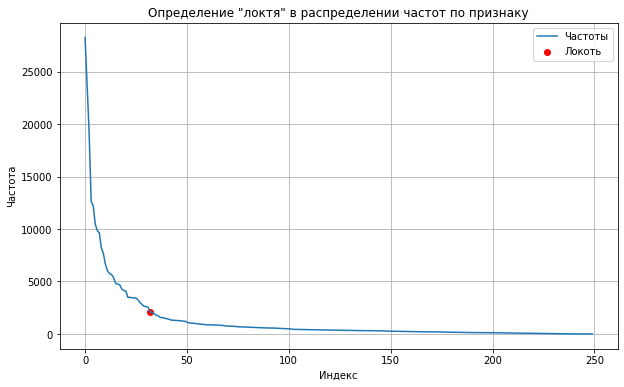

32

2092

In [43]:
elbow_finder('model')

По результату этого графика с точкой "локтя" можем принять за условную границу, отделяющую редкие и распространённые модели, точку с индексом 32. Т.е. всё, что встречается 2092 раза и реже, считаем редкими моделями.

Но просто так выполнять изменение редко встречающихся моделей будет, вероятно, не слишком корректно, так как категория "other" уже сейчас находится на втором месте по встречаемости в датасете. Подобный ход выведет его в топ-1. Нет уверенности в том, как это повлияет на репрезентативность работы модели и результата в целом.

Вместо изменения "model" всех редких моделей на значение "other", сделаем иначе - создадим категории в зависимости от бренда автомобиля. Например, получим:

- other_honda;
- other_kia;
- other_toyota;
- и т.д.

Тогда такие категории будут просто считаться набором относительно непопулярных моделей **внутри своего бренда**.

Для начала соберём список редких моделей "rare_models":

In [44]:
# Получение списка редких моделей, начиная с индекса 32
rare_models = model_counts.iloc[32:].index.tolist()

rare_models

['octavia',
 'fabia',
 'cooper',
 'clk',
 'micra',
 'x_reihe',
 'caddy',
 '80',
 'sharan',
 'scenic',
 'omega',
 'laguna',
 'civic',
 'leon',
 '1_reihe',
 '6_reihe',
 'i_reihe',
 'slk',
 'galaxy',
 'tt',
 'meriva',
 'yaris',
 'mx_reihe',
 '7er',
 'kangoo',
 'm_klasse',
 '500',
 'one',
 'arosa',
 'b_klasse',
 's_klasse',
 'vito',
 'bora',
 'colt',
 'escort',
 'berlingo',
 'beetle',
 'sprinter',
 'tigra',
 'v40',
 'transit',
 'fox',
 'z_reihe',
 'swift',
 'c_max',
 'corolla',
 'panda',
 'tiguan',
 'seicento',
 'insignia',
 '4_reihe',
 'v70',
 '156',
 'primera',
 'a1',
 'scirocco',
 'espace',
 'stilo',
 'touareg',
 '147',
 'almera',
 'avensis',
 'grand',
 'a5',
 'qashqai',
 'a8',
 'eos',
 'c3',
 'signum',
 'c5',
 'c4',
 'matiz',
 '5_reihe',
 's_max',
 'agila',
 'aygo',
 'ducato',
 'kaefer',
 'getz',
 'combo',
 'carisma',
 '100',
 'sl',
 'c2',
 'c1',
 'cordoba',
 'forfour',
 'a2',
 'altea',
 'cuore',
 'superb',
 'picanto',
 '601',
 'rio',
 'alhambra',
 'jetta',
 'up',
 'rav',
 'accord',
 '

Теперь используем метод "apply" в сочетании с функцией "transform_model", чтобы обновить значения моделей на нужные нам.

In [45]:
# Функция для преобразования модели
def transform_model(row):
    if row['model'] in rare_models or row['model'] == 'other':
        return f"other_{row['brand']}"
    else:
        return row['model']

In [46]:
# Применение функции к DataFrame
df['model'] = df.apply(transform_model, axis=1)

In [47]:
# Проверка результата
new_model_counts = df['model'].value_counts()

new_model_counts

other_other            58837
golf                   28246
3er                    19179
polo                   12628
corsa                  12197
other_mercedes_benz    11326
astra                  10475
other_volkswagen        9939
passat                  9835
a4                      9642
c_klasse                8174
5er                     7665
other_opel              7084
e_klasse                6631
other_audi              6432
other_ford              6032
a3                      6026
focus                   5750
fiesta                  5656
other_fiat              5630
other_renault           5620
a6                      5368
twingo                  4817
2_reihe                 4763
transporter             4687
fortwo                  4296
a_klasse                4133
vectra                  4094
other_bmw               3740
1er                     3497
mondeo                  3487
clio                    3459
touran                  3428
3_reihe                 3425
punto         

Как видно, категории "other" больше нет. Вместо этого мы получили новые категории "other_{брэнд_автомобиля}".

Выделяющейся категорией стала "other_other" по причине того, что в п.2.3.2 мы создали одноимённую категорию для брендов. Учитывая, что эта категория оказалась на 2 месте по встречаемости, в данном случае модели "other_other" и вовсе вышли на первое место.

Осталось разобраться с пропусками. Так как признак "model" содержит множество возможных вариантов даже в рамках своего бренда и типа кузова, в данном случае не видится надёжного способа заполнить такие пропуски.

Оставлять пропуски или же заполнять их условным значением "unknown" в данном случае в целом кажется допустимым, но для более надёжной оценки стоимости автомобиля лучшим вариантом кажется оставить в датасете как можно большее количество записей с известными значениями.

В реальности, как видно, датасет имеет недостатки, но в связи с этим в конце работы планируется в числе рекомендаций заказчику описать, почему следует обеспечить должное качество датасета.

Сейчас просто удалим все записи, где пропущены значения по признаку "model".

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               343597 non-null  int64 
 1   vehicle_type        309847 non-null  object
 2   registration_year   343597 non-null  int64 
 3   gearbox_type        326242 non-null  object
 4   power               343597 non-null  int64 
 5   model               326076 non-null  object
 6   driven_km           343597 non-null  int64 
 7   registration_month  343597 non-null  int64 
 8   fuel_type           314138 non-null  object
 9   brand               343597 non-null  object
 10  repaired            277731 non-null  object
 11  date_created        343597 non-null  object
 12  postal_code         343597 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 36.7+ MB


In [49]:
df = df.dropna(subset=['model'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326076 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               326076 non-null  int64 
 1   vehicle_type        297910 non-null  object
 2   registration_year   326076 non-null  int64 
 3   gearbox_type        311806 non-null  object
 4   power               326076 non-null  int64 
 5   model               326076 non-null  object
 6   driven_km           326076 non-null  int64 
 7   registration_month  326076 non-null  int64 
 8   fuel_type           302525 non-null  object
 9   brand               326076 non-null  object
 10  repaired            267783 non-null  object
 11  date_created        326076 non-null  object
 12  postal_code         326076 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 34.8+ MB


**Итог**:

Пропуски в столбце "model" успешно удалены.

Редко встрачающиеся модели автомобилей преобразованы в значения вида "other_{брэнд_автомобиля}".

#### Столбец "vehicle_type"

Как мы узнали из п.1.2., столбец `vehicle_type` содержит 37 490 пропусков или 11% строк от всего датасета.
Выведем число пропусков ещё раз:

In [50]:
df['vehicle_type'].isna().sum() 

28166

После удалений записей осталось 28 166 записей с пропущенным значением "vehicle_type".

Посмотрим, какие есть типы кузова, и нет ли среди них дублей.

In [51]:
df['vehicle_type'].value_counts()

sedan          86339
small          74908
wagon          61704
bus            27427
convertible    19038
coupe          14776
suv            11067
other           2651
Name: vehicle_type, dtype: int64

Всего 8 типов кузова, восьмой из которых "other" и является самой малой категорией.

Так как записей без указанного кузова достаточно ощутимое количество на весь датасет, удаление строк было бы не самым удачным решением.

Можно заполнить как можно большее количество строк наиболее вероятными для них значениями. Сделаем это следующим образом:
1. По каждой уникальной связке "brand" и "model" определим наиболее часто встречающийся для них тип кузова.
2. Заполним пропуски для каждой такой группы наиболее часто встречающимся кузовом;
3. Так как столбец "model" также содержит пропуски, вероятно, что не все пропуски в "vehicle_type" получится обработать таким образом. Поэтому следующим шагом заполним оставшиеся пропуски уже на основании только "brand";
4. Учитывая, что пропусков в поле "brand" нет, то ожидаем, что после 3 шага пропусков остаться не должно.

Напишем функцию fill_nan_by_mode(), где:

- ***p_category*** - категория, на основе которой будет вычисляться "мода";
- ***p_feature_full*** - признак, который будет заполняться на основании категории;
- ***p_sample_size*** - размер выборки для проверки работы функции;
- ***p_set_nan_conditions*** - условие, по которому часть значений могут быть переведены в NaN (опционально, принимает на вход операторы сравнения);
- ***p_nan_condition_value*** - условие, по которому часть значений могут быть переведены в NaN (опционально, принимает на вход числовое значение);

In [52]:
# Функция для заполнения пропусков на основе "моды"
def fill_nan_by_mode(p_category, 
                     p_feature_fill, 
                     p_sample_size=20, 
                     p_set_nan_condition='',
                     p_nan_condition_value=''):
    # Функционал на случай, если потребуется предварительно перевести значения в NaN по заданному простому условию
    if p_set_nan_condition != '':
        print('Приведение значений к NaN...')
        print(f'Выбрано условие {p_set_nan_condition} по значению {p_nan_condition_value}...')
        if p_set_nan_condition == '==':
            df[p_feature_fill] = df[p_feature_fill].apply(lambda x: np.nan if x == p_nan_condition_value else x)
        elif p_set_nan_condition == '>=':
            df[p_feature_fill] = df[p_feature_fill].apply(lambda x: np.nan if x >= p_nan_condition_value else x)
        elif p_set_nan_condition == '<=':
            df[p_feature_fill] = df[p_feature_fill].apply(lambda x: np.nan if x <= p_nan_condition_value else x)
        elif p_set_nan_condition == '!=':
            df[p_feature_fill] = df[p_feature_fill].apply(lambda x: np.nan if x != p_nan_condition_value else x)
        elif p_set_nan_condition == '>':
            df[p_feature_fill] = df[p_feature_fill].apply(lambda x: np.nan if x > p_nan_condition_value else x)
        elif p_set_nan_condition == '<':
            df[p_feature_fill] = df[p_feature_fill].apply(lambda x: np.nan if x < p_nan_condition_value else x)
        else:
            raise ValueError("Условие p_set_nan_condition указано неверно")
    
    # Выводим количество пропущенных значений до начала исправлений
    print('Пропущенных значений по признаку', df[p_feature_fill].reset_index().columns[1], '-',\
          df[p_feature_fill].isna().sum())
    
    # Группируем по признакам массива p_category, находим наиболее часто встречающееся p_feature_fill для каждой комбинации
    mode_feature = df.groupby(p_category)[p_feature_fill]\
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

    # Преобразуем результат в словарь
    feature_map = mode_feature.reset_index()\
    .set_index(p_category)[p_feature_fill].to_dict()
    
    # Собираем случайные строки для проверки результата работы функции
    v_fill_check = df[df[p_feature_fill].isna()].sample(p_sample_size).index.to_list()
    display(df.loc[v_fill_check, np.append(p_category, p_feature_fill)])
    
    # Функция для заполнения пропущенных значений p_feature_fill
    def fill_nan_helper(row):
        # Создаем ключ на основе значений признаков из p_category
        key = tuple(row[cat] for cat in p_category)
        if pd.isna(row[p_feature_fill]):
            return feature_map.get(key, np.nan)
        else:
            return row[p_feature_fill]
    
    # Применяем функцию к каждой строке DataFrame
    df[p_feature_fill] = df.apply(fill_nan_helper, axis=1)
    
    # Проверим результаты на выбранных строках
    print('Пропущенных значений по признаку', df[p_feature_fill].reset_index().columns[1], '-',\
          df[p_feature_fill].isna().sum())
    display(df.loc[v_fill_check, np.append(p_category, p_feature_fill)])

In [53]:
fill_nan_by_mode(['brand', 'model'], 'vehicle_type', p_sample_size=10)

Пропущенных значений по признаку vehicle_type - 28166


,brand,model,vehicle_type
326560,other,ibiza,NaN
71634,ford,fiesta,NaN
3862,other,other_other,NaN
224253,other,other_other,NaN
277418,ford,focus,NaN
326917,bmw,5er,NaN
142703,opel,zafira,NaN
179138,opel,astra,NaN
74541,bmw,3er,NaN
112952,renault,megane,NaN


Пропущенных значений по признаку vehicle_type - 0


/tmp/ipykernel_104/2524102915.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[p_feature_fill] = df.apply(fill_nan_helper, axis=1)


,brand,model,vehicle_type
326560,other,ibiza,small
71634,ford,fiesta,small
3862,other,other_other,small
224253,other,other_other,small
277418,ford,focus,wagon
326917,bmw,5er,sedan
142703,opel,zafira,bus
179138,opel,astra,sedan
74541,bmw,3er,sedan
112952,renault,megane,sedan


**Итог**:

Столбец "vehicle_type" обработан успешно.

#### Столбец "gearbox_type"

Посмотрим на уникальные значения признака "gearbox_type":

In [54]:
df['gearbox_type'].value_counts()

manual    249990
auto       61816
Name: gearbox_type, dtype: int64

Как видно, автомобилей с ручной коробкой передач существенно больше, чем с автоматической.

Также, выведем количество пропусков по данному признаку:

In [55]:
df['gearbox_type'].isna().sum() 

14270

Выполним аналогичную операцию по заполнению пропусков, как мы сделали это с признаком "vehicle_type" в п.2.3.3.
То есть, заполним пропуски наиболее часто встречающимися значениями, группируясь по бренду и модели автомобиля.

Также, можем дополнительно посмотреть, по каким категориям будут выбираться наиболее часто встречающиеся значения "gearbox_type".

In [56]:
df[df['gearbox_type'].isna()][['brand', 'model', 'gearbox_type']].drop_duplicates()

,brand,model,gearbox_type
15,ford,ka,NaN
16,volkswagen,polo,NaN
32,volkswagen,golf,NaN
37,renault,other_renault,NaN
69,opel,astra,NaN
94,opel,other_opel,NaN
110,opel,corsa,NaN
130,bmw,3er,NaN
145,audi,other_audi,NaN
197,audi,a3,NaN


Выполним заполнение пропусков на основе "моды" с помощью функции `fill_nan_by_mode`.

In [57]:
fill_nan_by_mode(['brand', 'model'], 'gearbox_type', p_sample_size=20)

Пропущенных значений по признаку gearbox_type - 14270


,brand,model,gearbox_type
107460,opel,astra,NaN
124003,volkswagen,golf,NaN
81143,volkswagen,transporter,NaN
194825,volkswagen,golf,NaN
16916,mercedes_benz,e_klasse,NaN
147186,other,fortwo,NaN
409,volkswagen,other_volkswagen,NaN
354305,volkswagen,polo,NaN
36959,volkswagen,golf,NaN
90007,other,fortwo,NaN


Пропущенных значений по признаку gearbox_type - 0


/tmp/ipykernel_104/2524102915.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[p_feature_fill] = df.apply(fill_nan_helper, axis=1)


,brand,model,gearbox_type
107460,opel,astra,manual
124003,volkswagen,golf,manual
81143,volkswagen,transporter,manual
194825,volkswagen,golf,manual
16916,mercedes_benz,e_klasse,auto
147186,other,fortwo,auto
409,volkswagen,other_volkswagen,manual
354305,volkswagen,polo,manual
36959,volkswagen,golf,manual
90007,other,fortwo,auto


**Итог**:

Столбец "gearbox_type" обработан успешно.

#### Столбец "fuel_type"

Посмотрим на уникальные значения признака "fuel_type":

In [58]:
df['fuel_type'].value_counts()

petrol      202254
gasoline     94504
lpg           4845
cng            534
hybrid         204
other          119
electric        65
Name: fuel_type, dtype: int64

In [59]:
df['fuel_type'].isna().sum() 

23551

Выполним заполнение пропусков на основе "моды" с помощью функции `fill_nan_by_mode`.

In [60]:
fill_nan_by_mode(['brand', 'model'], 'fuel_type', p_sample_size=20)

Пропущенных значений по признаку fuel_type - 23551


,brand,model,fuel_type
14136,other,other_other,NaN
349720,mercedes_benz,c_klasse,NaN
107565,other,fortwo,NaN
353950,opel,astra,NaN
157212,volkswagen,transporter,NaN
13,volkswagen,passat,NaN
146986,other,other_other,NaN
84495,other,other_other,NaN
232014,volkswagen,golf,NaN
205328,other,other_other,NaN


Пропущенных значений по признаку fuel_type - 0


/tmp/ipykernel_104/2524102915.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[p_feature_fill] = df.apply(fill_nan_helper, axis=1)


,brand,model,fuel_type
14136,other,other_other,petrol
349720,mercedes_benz,c_klasse,petrol
107565,other,fortwo,petrol
353950,opel,astra,petrol
157212,volkswagen,transporter,gasoline
13,volkswagen,passat,gasoline
146986,other,other_other,petrol
84495,other,other_other,petrol
232014,volkswagen,golf,petrol
205328,other,other_other,petrol


Помимо заполнения пропусков, следует также заменить редкие значения признака "fuel_type" на одну общую категорию "other" (которая уже существует с небольшом количестве).

Редко встречающимися признаками в данном случае можно считать всё, что не является "petrol" и "gasoline".
Кроме того, оба слова обозначают "бензин", но употребление этих слов может зависеть от региона. В частности, слово "Gasoline" используется в США и Канаде, а "Petrol" - в странах Европы, Австралии и других.

https://ru.hinative.com/questions/23742640

По этой причине следует объединить эти две категории в одну - "petrol". По итогу останется лишь две: "petrol" и "other".

In [61]:
df.loc[df['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

df['fuel_type'].value_counts()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


petrol      320309
lpg           4845
cng            534
hybrid         204
other          119
electric        65
Name: fuel_type, dtype: int64

Объединение к категории "petrol" успешно. Теперь объединим оставшиеся категории к "other".

In [62]:
df.loc[df['fuel_type'] != 'petrol', 'fuel_type'] = 'other'

df['fuel_type'].value_counts()

petrol    320309
other       5767
Name: fuel_type, dtype: int64

**Итог**:

Столбец "fuel_type" обработан успешно.

#### Столбец "driven_km"

Теперь рассмотрим столбец "driven_km". В первую очередь рассмотрим его через `value_counts()`, узнав распределение уникальных значений. Тем более, что по п.1.2. выглядит так, будто этот признак является категориальным, несмотря на его кажущуюся количественную природу.

In [63]:
df['driven_km'].value_counts()

150000    218580
125000     34388
100000     13754
90000      10998
80000       9562
70000       8170
60000       7110
50000       5921
40000       4659
5000        4280
30000       4120
20000       3520
10000       1014
Name: driven_km, dtype: int64

Как видно, признак **driven_km** действительно является категориальным, судя по количеству его значений и тому, как они выглядят.

Также, проверим этот признак на пропуски.

In [64]:
df['driven_km'].isna().sum() 

0

Пропуски отсутствуют. В данном случае единственное, что следует сделать с этим признаком для повышения эффективности машинного обучения - разбить его на меньшее количество категорий. Тем самым, мы избавимся от категорий с малым количеством автомобилей.

Преобразовывать признак будем с помощью функции `cut`, разбив его на 4 равных интервала.

In [65]:
df['driven_km'] = pd.cut(df['driven_km'], bins=4, labels=['low', 'medium', 'high', 'very_high'])

df['driven_km'].value_counts()

/tmp/ipykernel_104/2899870383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['driven_km'] = pd.cut(df['driven_km'], bins=4, labels=['low', 'medium', 'high', 'very_high'])


very_high    252968
high          34314
medium        21201
low           17593
Name: driven_km, dtype: int64

**Итог**:

Как видно, признак успешно разбит на 4 категории.

#### Столбец "repaired"

Посмотрим на уникальные значения столбца "repaired".

In [66]:
df['repaired'].value_counts()

no     235824
yes     31959
Name: repaired, dtype: int64

Проверим количество пропущенных значений:

In [67]:
df['repaired'].isna().sum()

58293

В данном случае признак можно было бы считать бинарным, если бы не 58 293 пропуска, которые можно интерпретировать как отдельную категорию. Данная категория слишком большая для того, чтобы удалять эти записи, а заменить на однозначное "yes" или "no" не представляется возможным.

Но способ преобразование "OrdinalEncoding" в дальнейшем потребует, чтобы в преобразовывающихся столбцах не было NaN-значений. Поэтому изменим их на "unknown". Тем более, этот признак сам по себе может влиять на ценообразование отличным образом от двух остальных категорий.

In [68]:
df['repaired'].fillna('unknown', inplace=True)

df['repaired'].value_counts()

/opt/conda/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


no         235824
unknown     58293
yes         31959
Name: repaired, dtype: int64

#### Столбец "registration_month"

Проверим столбец на наличие уникальных записей с помощью `value_counts()`. Ожидается, что количество категорий не должно превысить 12.

In [69]:
df['registration_month'].value_counts()

3     32631
6     29540
0     27631
4     27498
5     27335
7     25496
10    24691
11    22943
12    22822
9     22583
1     21624
8     21268
2     20014
Name: registration_month, dtype: int64

Судя по результату, здесь явно проблема с форматом представления месяцев. А именно - смешались варианты записи месяца в формате "от 0 до 11" и "от 1 до 12". При этом, определить корректный месяц для каждого автомобиля не представляется возможным.

Учитывая, что месяц в нашем случае потребуется лишь для определения возраста автомобиля, то глубокий анализ по работе с данным столбцом будет излишен. Мы просто изменим значение "0" на "1", тем самым приведя формат записи к формату "от 1 до 12". На подсчёт возраста автомобиля разница в 1 месяц повлияет крайне незначительно, поэтому данный ход выглядит уместным.

In [70]:
df.loc[df['registration_month'] == 0, 'registration_month'] = 1

df['registration_month'].value_counts()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


1     49255
3     32631
6     29540
4     27498
5     27335
7     25496
10    24691
11    22943
12    22822
9     22583
8     21268
2     20014
Name: registration_month, dtype: int64

**Итог**:

"Нулевой" месяц успешно искоренён, превратившись в первый.

#### Столбец "registration_year"

Проверим столбец на наличие уникальных записей с помощью `value_counts()`. Ожидается, что количество категорий не должно превысить 30-50 в силу специфики признака.

По результатам анализа из п.2.2.6 в датасете не может быть автомобилей, выпущенных позднее, чем 04.2016. Также, вряд ли здесь будут слишком старые автомобили. А если и будут, то они будут настолько редки, что такими данными можно будет пренебречь.

In [71]:
df['registration_year'].value_counts()

2000    21301
1999    20959
2005    20561
2006    19150
2003    18878
2001    18855
2004    18853
2002    18011
2007    16570
1998    16220
2008    14911
2009    14106
1997    13225
2010    10448
1996     9766
2011     9676
2017     8591
1995     8185
2016     7761
2012     6990
1994     4319
2013     4015
2018     3256
1993     3047
1992     2633
2014     2453
1991     2448
1990     2143
2015     1133
1989     1125
1988      838
1987      584
1985      562
1986      462
1980      378
1983      369
1984      334
1982      263
1978      229
1979      220
1970      212
1981      210
1972      176
1977      144
1974      144
1973      138
1976      134
1971      127
1975      108
1966       86
1969       84
1960       78
1967       75
1968       74
1965       61
1964       38
1963       37
1962       29
1910       25
1961       23
1959       16
1000       15
2019       15
1956       13
1950       13
5000       13
9999       13
1958       12
1955        9
1957        9
1953        8
1951  

По результатам видно, что в датасете есть достаточное количество записей с явно некорректными записями. Всего можно разделить некорректные записи на 3 группы:

- Даты из далёкого будущего;
- Даты из далёкого прошлого и далёкого прошлого (колесницы?);
- Даты из ближайшего будущего.

Даты из ближайшего будущего выделили отдельно, так как по какой-то причине таких записей достаточно много с учётом того, что мы явно отметили, что датасет не должен иметь данных по автомобилям, выпущенным после 04.2016.

Сначала рассмотрим записи с аномально высокими годами далёкого будущего. Отсортируем предыдущий результат по убыванию годов.

In [72]:
df['registration_year'].value_counts().reset_index().sort_values(by='index', ascending=False)

,index,registration_year
66,9999,13
103,9000,1
104,8500,1
102,8200,1
95,8000,2
115,7800,1
108,7100,1
79,7000,3
111,6500,1
112,6000,1


Судя по результату, аномально высокие года можно выделить начиная с 2066 года. Правда, резкое снижение начинается с 2019 года. Но всё же 2019 год пока отнесём к датам ближайшего будущего.

Попробуем исправить для них года с помощью функции `fill_nan_by_mode()`. Есть риск того, что для каких-то автомобилей будет указан не совсем корректный год, учитывая наши предыдущие изменения на категории "other". Поэтому предварительно избавимся от всех автомобилей с аномально высокими годами выпуска и при этом, содержащими "other".

In [73]:
df = df.loc[~((df['model'].str.contains('other')) & (df['registration_year'] >= 2066))]

df

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code
0,480,sedan,1993,manual,0,golf,very_high,1,petrol,volkswagen,unknown,2016-03-24 00:00:00,70435
2,9800,suv,2004,auto,163,other_other,very_high,8,petrol,other,unknown,2016-03-14 00:00:00,90480
3,1500,small,2001,manual,75,golf,very_high,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074
4,3600,small,2008,manual,69,other_other,high,7,petrol,other,no,2016-03-31 00:00:00,60437
5,650,sedan,1995,manual,102,3er,very_high,10,petrol,bmw,yes,2016-04-04 00:00:00,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,other_other,very_high,5,petrol,other,yes,2016-03-19 00:00:00,96465
354363,1150,bus,2000,manual,0,zafira,very_high,3,petrol,opel,no,2016-03-27 00:00:00,26624
354366,1199,convertible,2000,auto,101,fortwo,very_high,3,petrol,other,no,2016-03-05 00:00:00,26135
354367,9200,bus,1996,manual,102,transporter,very_high,3,petrol,volkswagen,no,2016-03-19 00:00:00,87439


Теперь выполним функцию `fill_nan_by_mode()` в режиме перевода в NaN всех значений "registration_year" старше 2066 года.

In [74]:
fill_nan_by_mode(['brand', 'model'], 
                  'registration_year', 
                  p_sample_size=10, 
                  p_set_nan_condition='>=', 
                  p_nan_condition_value=2066)

Приведение значений к NaN...
Выбрано условие >= по значению 2066...
Пропущенных значений по признаку registration_year - 31


,brand,model,registration_year
28965,mercedes_benz,a_klasse,NaN
66453,volkswagen,golf,NaN
79383,opel,zafira,NaN
231437,opel,corsa,NaN
301279,volkswagen,transporter,NaN
53678,volkswagen,golf,NaN
326556,volkswagen,golf,NaN
26382,mercedes_benz,a_klasse,NaN
322234,volkswagen,golf,NaN
331753,bmw,1er,NaN


Пропущенных значений по признаку registration_year - 0


,brand,model,registration_year
28965,mercedes_benz,a_klasse,1999.0
66453,volkswagen,golf,1999.0
79383,opel,zafira,2005.0
231437,opel,corsa,2000.0
301279,volkswagen,transporter,1996.0
53678,volkswagen,golf,1999.0
326556,volkswagen,golf,1999.0
26382,mercedes_benz,a_klasse,1999.0
322234,volkswagen,golf,1999.0
331753,bmw,1er,2008.0


Посмотрим на распределение данных после исправления сверхвысоких годов:

In [75]:
df['registration_year'].value_counts().reset_index().sort_values(by='index', ascending=False)

,index,registration_year
61,2019.0,15
22,2018.0,3256
16,2017.0,8591
18,2016.0,7761
28,2015.0,1133
25,2014.0,2453
21,2013.0,4015
19,2012.0,6990
15,2011.0,9676
13,2010.0,10448


От некорректно сверхвысоких значений годов избавились. Теперь взглядем на некорректно сверхнизкие значения.

In [76]:
df['registration_year'].value_counts().reset_index().sort_values(by='index', ascending=True)

,index,registration_year
62,1000.0,15
93,1001.0,1
85,1234.0,2
90,1300.0,2
94,1400.0,1
89,1500.0,2
97,1600.0,1
92,1602.0,1
75,1800.0,3
58,1910.0,25


Судя по равномерному распределению данных, всё выглядит так, что однозначно некорректно низкие даты начинаются либо с 1910 года, либо с 1800 года. 

Среди них также должны быть те, кто попал под приведение к категории "other" из-за редкости таких моделей и их брендов.
По этой причине выполним приведение к NaN всех записей с датой "1989" и меньше. Это будет считаться отдельной категорией из разряда "ранние года".

In [77]:
df['registration_year'] = df['registration_year'].apply(lambda x: 1989 if x <= 1989 else x)

Посмотрим на распределение теперь и проверим, остались ли сверхнизкие года.

In [78]:
df['registration_year'].value_counts().reset_index().sort_values(by='index', ascending=True)

,index,registration_year
19,1989.0,7539
28,1990.0,2143
27,1991.0,2448
25,1992.0,2633
24,1993.0,3047
21,1994.0,4319
17,1995.0,8185
14,1996.0,9767
12,1997.0,13227
9,1998.0,16220


Сверхнизких годов не осталось.

Остаётся взглянуть на автомобили с выпуском после 2016.04 и разобраться, что это за автомобили из будущего. Возьмём выборку по таким автомобилям.

In [79]:
print(df.loc[(df['registration_year'] >= 2016) & (df['registration_month'] >= 5)]['registration_year'].count())

df.loc[(df['registration_year'] >= 2016) & (df['registration_month'] >= 5)].sample(15)

9888


,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code
277486,1600,sedan,2018.0,manual,69,golf,very_high,12,petrol,volkswagen,unknown,2016-04-01 00:00:00,98617
209634,1800,wagon,2016.0,manual,100,other_opel,very_high,6,petrol,opel,no,2016-03-27 00:00:00,96279
285941,2500,small,2016.0,manual,0,other_other,very_high,8,petrol,other,unknown,2016-03-10 00:00:00,31707
17801,2300,bus,2017.0,manual,70,transporter,very_high,5,petrol,volkswagen,unknown,2016-03-14 00:00:00,38531
342540,3199,sedan,2016.0,manual,192,3er,very_high,8,petrol,bmw,no,2016-03-28 00:00:00,71093
339896,350,small,2016.0,manual,58,twingo,very_high,12,petrol,renault,no,2016-03-05 00:00:00,60313
321990,2550,small,2018.0,manual,82,other_other,very_high,10,petrol,other,no,2016-03-17 00:00:00,86368
323000,3600,sedan,2016.0,manual,140,a_klasse,very_high,10,petrol,mercedes_benz,no,2016-03-16 00:00:00,78048
6375,4200,small,2017.0,manual,110,other_other,very_high,10,petrol,other,no,2016-03-15 00:00:00,21614
348527,4499,sedan,2016.0,manual,125,astra,very_high,6,petrol,opel,no,2016-03-15 00:00:00,45478


Подсчёт получился грубым, так как в выборку не попали автомобили с месяцев выпуска от 1 до 4 включительно. Этот момент будет учтён в дальнейшем, когда у нас будет полноценный столбец с датой выпуска автомобиля. А пока мы видим, что у нас потенциально более 10000 подобных автомобилей с аномальной датой производства.

С первого взгляда по данным непонятно, что их выделяет, кроме самой даты регистрации.

Учитывая, что наличие таких автомобилей может помешать вычислению возраста автомобиля (п 2.5.1), следует удалить данные строки.

Удаление строк автомобилей из будущего выполним в п.2.5.1.

#### Столбец "power"

Судя по гистограмме из п. 1.2. "Обзор датасета", для всех или практически всех объектов по признаку `power` прописано значение "0". Посмотрим на числовое распределение данных:

In [80]:
df['power'].describe()

count    326049.000000
mean        111.975955
std         182.771677
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Как видно, разброс значений от минимального до максимального очень большой.
По этой причине гистограма из п.1.2 и выглядит столь неинформативно.

Также, отобразим гистограмму и график `boxplot`:

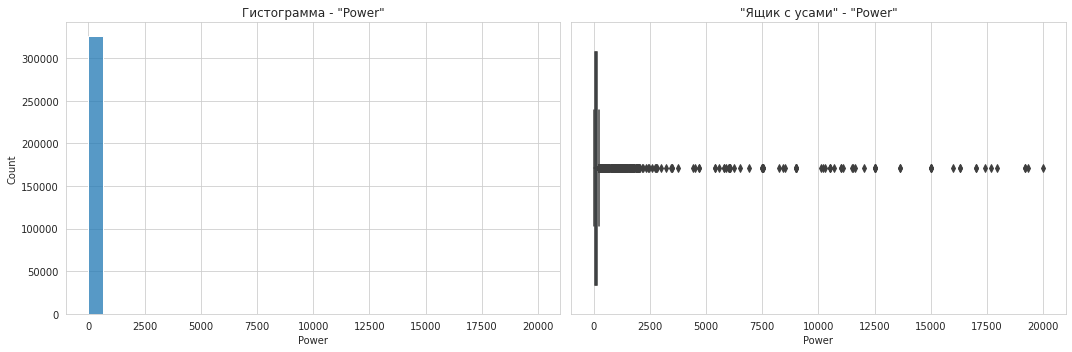

In [81]:
# Устанавливаем стиль визуализации графиков
sns.set_style("whitegrid")

# Инициализируем фигуру matplotlib
# Создаём 1 строку и 2 столбца подграфиков с размером фигуры 15x5.
f, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма по столбцу "Power"
sns.histplot(df['power'], bins=30, ax=axes[0], kde=False)
axes[0].set_title('Гистограмма - "Power"')
axes[0].set_xlabel('Power')
axes[0].set_ylabel('Count')

# "Ящик с усами" по столбцу "Power"
sns.boxplot(x=df['power'], ax=axes[1])
axes[1].set_title('"Ящик с усами" - "Power"')
axes[1].set_xlabel('Power')

# Отображаем графики
plt.tight_layout()
plt.show()

Всего можно выделить 3 аномальных ситуации:
- Нулевое значение мощности;
- Слишком высокие значения мощности;
- Слишком низкие значения мощности.

Разберёмся отдельно по каждой из ситуаций.

##### Нулевое значение мощности

Нулевое значение мощности можно считать корректным, если принять ноль за "неизвестно".
Посмотрим, сколько всего таких объектов на весь датасет:

In [82]:
print('Всего автомобилей с "нулевым" значением мощности:', len(df[(df['power'] == 0)]))
print('Процент от общего количества:', round((len(df[(df['power'] == 0)]) / len(df) * 100), 2), '%')

Всего автомобилей с "нулевым" значением мощности: 31313
Процент от общего количества: 9.6 %


Получается, что всего автомобилей с нулевым (неизвестным) значением мощности более 9 процентов.

##### Слишком высокие значения мощности

Слишком большие значения следует обработать, так как в отличие от "нулевой" мощности это набор из разнообразных значений, которые сами по себе не будут восприняты моделью как одна категория.

Попробуем разобраться, какие значения можно считать "слишком высокими".
Обратимся к странице Википедии, содержащей список автомобилей с наиболее высокой мощностью:

https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output#Most_powerful_production_cars

Как видно, на момент 2023 года самый мощный автомобиль имеет мощность 2 039 л.с.
С учётом того, что мы имеем датасет 2016 года, самый мощный автомобиль имел мощность 1521 л.с.

Но судя по содержимому страницы, большинство этих примеров - достаточно штучные образцы с производством всего в несколько десятков или сотен экземпляров. Минимально мощный из таких редких образцов имеет мощность 814 л.с. Посмотрим, сколько всего автомобилей имеют мощность в пределах от 800 л.с. до 1521 л.с.

In [83]:
len(df[(df['power'] >= 800) & (df['power'] <= 1521)])

119

Всего 119 автомобилей. Посмотрим на эти данные по гистограмме:

<AxesSubplot:>

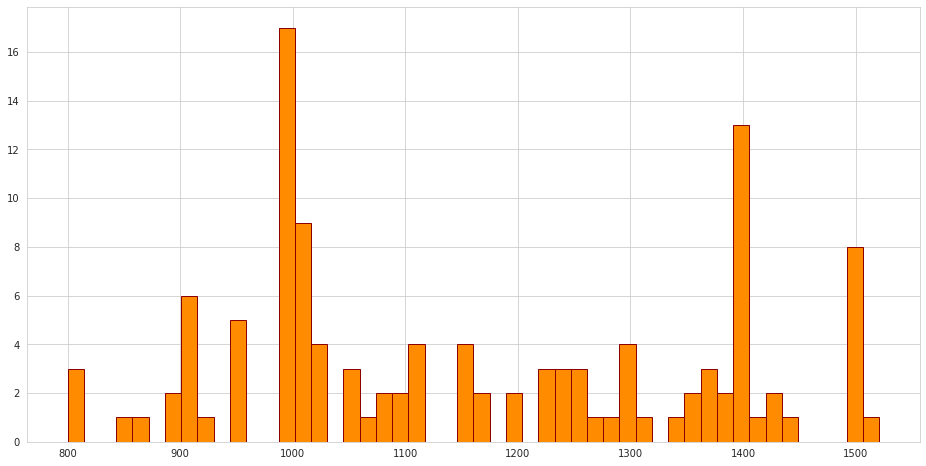

In [84]:
display(
    df[(df["power"] >= 800) & (df["power"] <= 1521)]["power"].hist(
        bins=50, figsize=(16, 8), color="darkorange", ec="darkred"
    )
)

По такому распределению сложно сказать, действительно ли данные заполнены некорректно, или же нет.
Посмотрим на распределение автомобилей от отметки 143 л.с. (3 квантиль из числового описания) до 800 л.с. Таким образом попробуем узнать, есть ли условная граница, где резко начинается рост заявленной мощности.

<AxesSubplot:>

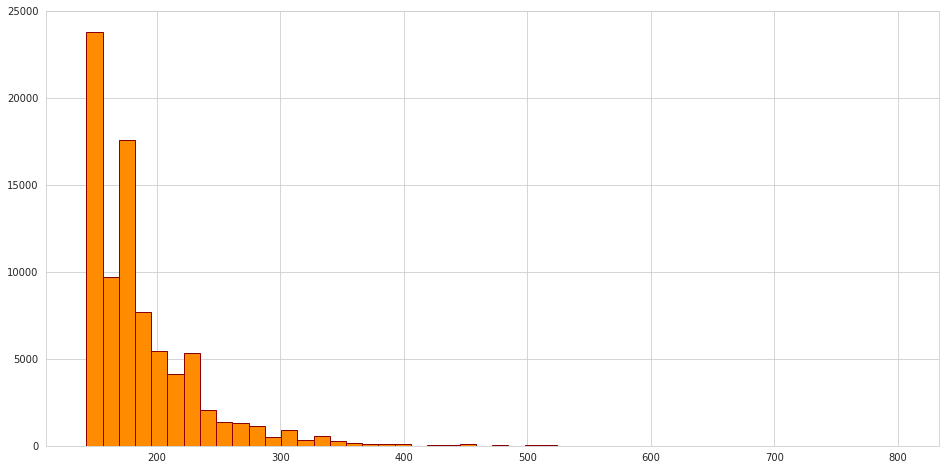

In [85]:
display(
    df[(df["power"] >= 143) & (df["power"] <= 800)]["power"].hist(
        bins=50, figsize=(16, 8), color="darkorange", ec="darkred"
    )
)

Ярко выраженной точки роста или провала нет. Тем не менее, возьмём отметку в "350" за условную точку, с которой начинаются крайне редкие объекты. Такие редкие объекты могут негативно повлиять на качество обучения модели, поэтому тем или иным образом лучше от них избавиться.

Посчитаем, сколько таких объектов, а также их процент от общего количества записей в таблице.

In [86]:
print('Всего автомобилей крайне высокими значениями мощности:', len(df[(df['power'] >= 350)]))
print('Процент от общего количества:', round((len(df[(df['power'] >= 350)]) / len(df) * 100), 2), '%\n')

Всего автомобилей крайне высокими значениями мощности: 1057
Процент от общего количества: 0.32 %



Количество автомобилей с аномально высокими значениями мощности всего 0,32 процента от всего количества объектов.

##### Слишком низкие значения мощности

Посмотрим, как распределяются данные со значением мощности менее, чем 100 лошадиных сил (значение, близкое к медиане).

<AxesSubplot:>

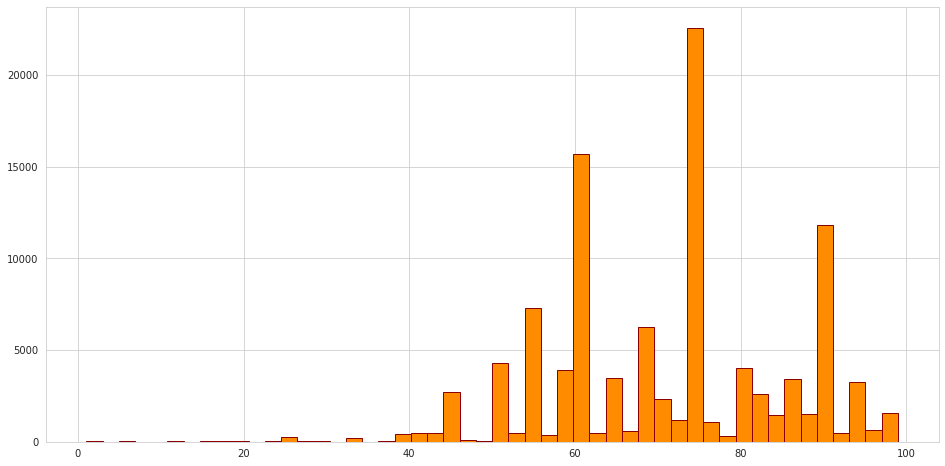

In [87]:
display(
    df[(df["power"] !=0) & (df["power"] < 100)]["power"].hist(
        bins=50, figsize=(16, 8), color="darkorange", ec="darkred"
    )
)

По гистограмме видно, что на отметке примерно в 50 л.с. происходит достаточно резкий спад количества автомобилей с более низкими значениями. Посчитаем, сколько их всего:

In [88]:
len(df[(df['power'] != 0) & (df['power'] < 50)])

5112

In [89]:
# Найдём долю от общего количества записей в датасете
round((len(df[(df['power'] != 0) & (df['power'] < 50)]) / df['power'].count() * 100), 2)

1.57

Всего 5112 автомобилей с крайне малыми значениями мощности, что является менее, чем 2 процентами от всего датасета.

##### Обработка значений мощности

Учитывая информацию выше, можно выбрать следующие подходы к предобработке данных в этом столбце:

- Для автомобилей с "нулевым" значением мощности, коих более 11% от общего количества объектов в датасете, переведём нулевое значениие в NaN. NaN-значения примем за то, что это неизвестные/неуказанные значения. Модель машинного обучения LightGBM должна принять это за отдельную большую категорию;
- Мощность автомобилей с высокими значениями (>= 350 л.с.), коих 0,35% от общего количества, считаем либо ошибочными, либо крайне редкими значениями, которые будут являться просто шумами для модели. Их мощность приравняем к медианному значению мощности каждого бренда.
- Мощность автомобилей с крайне малыми значениями мощности (50 л.с. и менее) составляет 1,69% от общего количества. Мощность таких автомобилей также можно приравнять к медианной мощности каждого бренда без серьёзного искажения данных.

Найдём медианное значение мощности для каждого бренда:

In [90]:
median_powers = df.groupby('brand')['power'].median().reset_index()

median_powers

,brand,power
0,audi,143
1,bmw,150
2,fiat,68
3,ford,95
4,mercedes_benz,143
5,opel,90
6,other,100
7,peugeot,92
8,renault,75
9,volkswagen,95


Для дальнейшей проверки работоспособности наших действий возьмём в пример строку с максимальной мощностью.

In [91]:
df.loc[df['power'].sort_values(ascending=False).index].head(1)

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code
219584,4300,coupe,1999.0,auto,20000,other_mercedes_benz,very_high,1,petrol,mercedes_benz,no,2016-03-09 00:00:00,19406


Зафиксировали, что это "mercedes_benz" со значением "power" = 20000 (строка 219584).

Ожидаем, что значение мощности поменяется на 143.

In [92]:
# Установим 'brand' как индекс
median_powers.set_index('brand', inplace=True)

# Используем map для создания сопоставления 'brand' и 'power'
power_map = df['brand'].map(median_powers['power'])

# Обновляем значения, где мощность 350 или больше
df.loc[df['power'] >= 350, 'power'] = power_map

# Обновляем значения, где мощность 50 или меньше и не ноль
df.loc[(df['power'] <= 50) & (df['power'] != 0), 'power'] = power_map

# Замена 0 на NaN
df['power'].replace(0, np.nan, inplace=True)

# Проверяем конкретную запись
df.loc[[219584]]

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code
219584,4300,coupe,1999.0,auto,143.0,other_mercedes_benz,very_high,1,petrol,mercedes_benz,no,2016-03-09 00:00:00,19406


Значение "power" действительно обновилось до 143.

Убедимся, что в датасете больше не осталось автомобилей со значением мощности более 350 л.с.

In [93]:
df[df['power'] > 350]['power'].count()

0

Аналогично проверим наличие автомобилей с низким уровнем мощности.

In [94]:
df[(df['power'] != 0) & (df['power'] < 50)]['power'].count()

0

Проверим, остались ли автомобили с нулевым значением мощности.

In [95]:
print('Всего автомобилей с "нулевым" значением мощности:', len(df[(df['power'] == 0)]))

Всего автомобилей с "нулевым" значением мощности: 0


И также убедимся, что значения мощности других автомобилей остались корректными.
Для этого выведем несколько случайных строк из датасета с той же маркой "mercedes_benz".

In [96]:
df[df['brand'] == 'mercedes_benz'].sample(15)

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code
59607,450,small,1999.0,auto,102.0,a_klasse,very_high,8,petrol,mercedes_benz,no,2016-03-16 00:00:00,87600
135578,1199,sedan,1996.0,manual,NaN,e_klasse,very_high,8,petrol,mercedes_benz,unknown,2016-03-09 00:00:00,40589
288459,1599,sedan,1998.0,manual,95.0,c_klasse,very_high,8,petrol,mercedes_benz,no,2016-03-14 00:00:00,21109
76068,11900,sedan,2007.0,manual,183.0,c_klasse,very_high,5,petrol,mercedes_benz,no,2016-03-30 00:00:00,47228
71900,950,sedan,1991.0,manual,118.0,e_klasse,very_high,3,petrol,mercedes_benz,unknown,2016-03-21 00:00:00,51647
342194,1400,sedan,1999.0,manual,60.0,a_klasse,very_high,6,petrol,mercedes_benz,no,2016-03-26 00:00:00,41352
148294,3550,sedan,2002.0,auto,129.0,c_klasse,very_high,11,petrol,mercedes_benz,no,2016-03-09 00:00:00,13359
152756,1200,wagon,1999.0,manual,170.0,c_klasse,very_high,1,petrol,mercedes_benz,yes,2016-03-10 00:00:00,35279
58392,7200,sedan,2004.0,auto,150.0,e_klasse,very_high,6,petrol,mercedes_benz,unknown,2016-03-05 00:00:00,44339
146504,6950,convertible,1998.0,auto,NaN,other_mercedes_benz,very_high,7,petrol,mercedes_benz,no,2016-03-11 00:00:00,59439


И посмотирм на числовое описание данных:

In [97]:
df['power'].describe()

count    294736.000000
mean        121.083536
std          49.638763
min          51.000000
25%          84.000000
50%         110.000000
75%         150.000000
max         349.000000
Name: power, dtype: float64

**Итог**:

Высокие и низкие значения мощности обработаны корректно.
Нулевые значения было решено не обрабатывать, т.к. рассчитываем на то, что модель интерпретирует это как отдельную категорию. Которую мы уже можем в свою очередь интерпретировать как условно неизвестное/неуказанное значение мощности.

### Проверка на наличие дублей

Проверим датасет на наличие полных дублей:

In [98]:
df.duplicated().sum()

10100

Всего в датасете 10100 полных дублей. Хоть в датасете и нет явного "ключа", по которому можно определять уникальность записи (по типу идентификатора объявления), но вероятность того, что абсолютно значения всех сойдутся в таком большом количества, достаточно низка.

Поэтому избавимся от таких дублей:

In [99]:
df.drop_duplicates(inplace=True)

df.duplicated().sum()

0

In [100]:
df['price'].count()

315949

В датасете осталось 315949 записей после удаления полных дублей.

### Создание новых признаков

#### Признак "car_age_years"

Признак `car_age_years` создаётся на основе столбцов:
- **date_created**;
- **registration_year**;
- **registration_month**.

Для начала создадим временный столбец registration_date в формате "datetime", сформировав его на основе столбцов "registration_year" и "registration_month".

In [101]:
# Создание столбца даты регистрации
df['registration_date'] = pd.to_datetime(df['registration_year'].astype(int).astype(str) + '-' +
                                         df['registration_month'].astype(int).astype(str) + '-01')

Убедимся, что столбец создан:

In [102]:
display(df.sample(3))

df.info()

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code,registration_date
172923,1150,small,1999.0,manual,54.0,corsa,very_high,10,petrol,opel,no,2016-03-07 00:00:00,48496,1999-10-01
17242,4200,small,2009.0,manual,75.0,clio,high,3,petrol,renault,no,2016-03-22 00:00:00,50765,2009-03-01
144489,5199,wagon,2008.0,manual,140.0,golf,very_high,3,petrol,volkswagen,no,2016-04-02 00:00:00,18184,2008-03-01


<class 'pandas.core.frame.DataFrame'>
Int64Index: 315949 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   price               315949 non-null  int64         
 1   vehicle_type        315949 non-null  object        
 2   registration_year   315949 non-null  float64       
 3   gearbox_type        315949 non-null  object        
 4   power               285234 non-null  float64       
 5   model               315949 non-null  object        
 6   driven_km           315949 non-null  category      
 7   registration_month  315949 non-null  int64         
 8   fuel_type           315949 non-null  object        
 9   brand               315949 non-null  object        
 10  repaired            315949 non-null  object        
 11  date_created        315949 non-null  object        
 12  postal_code         315949 non-null  int64         
 13  registration_date   315949 no

Столбец успешно создан и имеет ожидаемый нами тип данных.

Далее нам необходимо привести столбец "date_created" к типу данных "datetime", чтобы у нас корректно работало сравнение дат для дальнейших операций.

In [103]:
# Преобразование 'DateCreated' в datetime
df['date_created'] = pd.to_datetime(df['date_created'])

display(df.sample(3))

df.info()

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code,registration_date
29972,1500,wagon,1998.0,manual,150.0,other_other,very_high,10,petrol,other,no,2016-03-26,4808,1998-10-01
141152,3900,small,2009.0,manual,58.0,twingo,medium,2,petrol,renault,no,2016-03-26,47638,2009-02-01
125234,13999,sedan,2012.0,manual,116.0,1er,very_high,2,petrol,bmw,no,2016-04-02,54550,2012-02-01


<class 'pandas.core.frame.DataFrame'>
Int64Index: 315949 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   price               315949 non-null  int64         
 1   vehicle_type        315949 non-null  object        
 2   registration_year   315949 non-null  float64       
 3   gearbox_type        315949 non-null  object        
 4   power               285234 non-null  float64       
 5   model               315949 non-null  object        
 6   driven_km           315949 non-null  category      
 7   registration_month  315949 non-null  int64         
 8   fuel_type           315949 non-null  object        
 9   brand               315949 non-null  object        
 10  repaired            315949 non-null  object        
 11  date_created        315949 non-null  datetime64[ns]
 12  postal_code         315949 non-null  int64         
 13  registration_date   315949 no

Тип данных успешно изменён, содержимое осталось корректным.

In [104]:
df[df['date_created'] > '2016-04']

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code,registration_date
5,650,sedan,1995.0,manual,102.0,3er,very_high,10,petrol,bmw,yes,2016-04-04,33775,1995-10-01
8,14500,bus,2014.0,manual,125.0,other_ford,low,8,petrol,ford,unknown,2016-04-04,94505,2014-08-01
11,2799,wagon,2005.0,manual,140.0,passat,very_high,12,petrol,volkswagen,yes,2016-04-07,57290,2005-12-01
30,3300,sedan,1995.0,auto,113.0,e_klasse,very_high,1,petrol,mercedes_benz,no,2016-04-03,53879,1995-01-01
47,2100,wagon,1998.0,auto,193.0,5er,very_high,2,petrol,bmw,no,2016-04-03,86157,1998-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354347,800,wagon,2000.0,manual,101.0,astra,very_high,11,petrol,opel,yes,2016-04-03,58730,2000-11-01
354350,1400,sedan,2001.0,manual,125.0,astra,very_high,2,petrol,opel,no,2016-04-02,23820,2001-02-01
354356,999,convertible,2000.0,manual,95.0,megane,very_high,4,petrol,renault,unknown,2016-04-04,88477,2000-04-01
354358,1490,small,1998.0,manual,95.0,lupo,very_high,9,petrol,volkswagen,no,2016-04-04,48653,1998-09-01


В пункте 2.3.10 мы обнаружили, что часть автомобилей якобы была выпущена после того, как было размещено объявление о продаже, что противоречит логике.

Для корректного подсчёта возраста автомобиля нам нужно избавиться от подобных аномалий. Проверим, сколько всего подобных автомобилей, сравнив поля "date_created" и "registration_date".

In [105]:
# Ищем те автомобили, дата производства которых позже, чем дата размещения
df[df['registration_date'] > df['date_created']]

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code,registration_date
22,2900,wagon,2018.0,manual,90.0,other_opel,very_high,5,petrol,opel,no,2016-03-23,49716,2018-05-01
26,5555,small,2017.0,manual,125.0,other_other,very_high,4,petrol,other,no,2016-03-10,31139,2017-04-01
31,899,small,2016.0,manual,60.0,clio,very_high,6,petrol,renault,unknown,2016-03-29,37075,2016-06-01
35,350,sedan,2016.0,manual,75.0,golf,very_high,4,petrol,volkswagen,no,2016-03-08,19386,2016-04-01
48,7750,sedan,2017.0,manual,80.0,golf,high,1,petrol,volkswagen,unknown,2016-03-25,48499,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354198,1350,bus,2016.0,manual,NaN,other_mercedes_benz,very_high,8,petrol,mercedes_benz,yes,2016-03-10,26427,2016-08-01
354203,2140,small,2018.0,manual,80.0,fiesta,very_high,6,petrol,ford,no,2016-03-17,44866,2018-06-01
354253,1250,small,2018.0,manual,NaN,corsa,very_high,1,petrol,opel,unknown,2016-03-25,45527,2018-01-01
354289,5000,small,2017.0,manual,120.0,other_other,very_high,7,petrol,other,yes,2016-03-05,15518,2017-07-01


In [106]:
print('Всего автомобилей с аномальной датой производства:', len(df[df['registration_date'] > df['date_created']]))
print('Процент от общего количества:', round((len(df[df['registration_date'] > df['date_created']]) / len(df) * 100), 2), '%')

Всего автомобилей с аномальной датой производства: 15936
Процент от общего количества: 5.04 %


Всего оказалось 15936 автомобилей, что является примерно 5 процентами от общего количества записей (с учётом всей предыдущей предобработки данных).

Посмотрим также, какие даты производства являются аномальными и есть ли среди них те, что меньше, чем апрель 2016 года (предположительная текущая дата датасата на основе анализа из п. 2.2.6).

In [107]:
df[df['registration_date'] > df['date_created']]['registration_date']\
.dt.strftime('%Y-%m').value_counts().reset_index().sort_values(by='index')

,index,registration_date
16,2016-04,449
8,2016-05,568
5,2016-06,608
13,2016-07,481
15,2016-08,449
19,2016-09,420
10,2016-10,511
17,2016-11,433
21,2016-12,379
0,2017-01,2486


Оказывается, все аномальные даты производства начинаются с 2016.04. Во всём остальном датасете нет ни одной записи, где автомобиль был бы выпущен после даты размещения объявления.

Так как подобные аномальные записи помешают корректному вычислению возраста автомобиля, и учитывая, что их всего 5% от текущего датасета, данные записи удалим.

Не видно очевидного способа привести эти данные к корректным значениям, при этом, не исказив значение возраста автомобиля.

In [108]:
df.loc[~(df['registration_date'] > df['date_created'])]

,price,vehicle_type,registration_year,gearbox_type,power,model,driven_km,registration_month,fuel_type,brand,repaired,date_created,postal_code,registration_date
0,480,sedan,1993.0,manual,NaN,golf,very_high,1,petrol,volkswagen,unknown,2016-03-24,70435,1993-01-01
2,9800,suv,2004.0,auto,163.0,other_other,very_high,8,petrol,other,unknown,2016-03-14,90480,2004-08-01
3,1500,small,2001.0,manual,75.0,golf,very_high,6,petrol,volkswagen,no,2016-03-17,91074,2001-06-01
4,3600,small,2008.0,manual,69.0,other_other,high,7,petrol,other,no,2016-03-31,60437,2008-07-01
5,650,sedan,1995.0,manual,102.0,3er,very_high,10,petrol,bmw,yes,2016-04-04,33775,1995-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,3999,wagon,2005.0,manual,150.0,3er,very_high,5,petrol,bmw,no,2016-04-02,81825,2005-05-01
354362,3200,sedan,2004.0,manual,225.0,other_other,very_high,5,petrol,other,yes,2016-03-19,96465,2004-05-01
354366,1199,convertible,2000.0,auto,101.0,fortwo,very_high,3,petrol,other,no,2016-03-05,26135,2000-03-01
354367,9200,bus,1996.0,manual,102.0,transporter,very_high,3,petrol,volkswagen,no,2016-03-19,87439,1996-03-01


In [109]:
print('Строк в таблице до удаления:', df['registration_year'].count())

df = df.loc[~(df['registration_date'] > df['date_created'])]

print('Строк в таблице после удаления:', df['registration_year'].count())

Строк в таблице до удаления: 315949
Строк в таблице после удаления: 300013


Убедимся, что у нас не осталось подобных аномалий:

In [110]:
df[df['registration_date'] > df['date_created']]['registration_date'].count()

0

Теперь мы можем вычислить возраст автомобиля.

In [111]:
# Вычисление разницы в годах как количество дней, деленное на 365.25 (для учёта високосных годов)
df['car_age_years'] = (df['date_created'] - df['registration_date']).dt.days / 365.25

# Округление возраста автомобиля до целых лет
df['car_age_years'] = df['car_age_years'].astype(int)

display(df[['registration_year', 'registration_month', 'date_created', 'car_age_years']])

/tmp/ipykernel_104/3102882635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['car_age_years'] = (df['date_created'] - df['registration_date']).dt.days / 365.25
/tmp/ipykernel_104/3102882635.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['car_age_years'] = df['car_age_years'].astype(int)


,registration_year,registration_month,date_created,car_age_years
0,1993.0,1,2016-03-24,23
2,2004.0,8,2016-03-14,11
3,2001.0,6,2016-03-17,14
4,2008.0,7,2016-03-31,7
5,1995.0,10,2016-04-04,20
...,...,...,...,...
354360,2005.0,5,2016-04-02,10
354362,2004.0,5,2016-03-19,11
354366,2000.0,3,2016-03-05,16
354367,1996.0,3,2016-03-19,20


Возраст автомобилей выглядит корректно. На всякий случай проверим числовое описание по столбцу "car_age_years".

In [112]:
df['car_age_years'].describe()

count    300013.000000
mean         12.600834
std           5.777397
min           0.000000
25%           8.000000
50%          13.000000
75%          16.000000
max          27.000000
Name: car_age_years, dtype: float64

Числовое описание выглядит корректным. Теперь мы можем удалить столбцы "registration_date", "registration_month" и "registration_year" за ненадобостью. 

In [113]:
try:
    df = df.drop(columns=['registration_date', 'registration_month', 'registration_year', 'date_created'])
    print('Столбцы удалены')
except:
    print('Столбцы уже удалены')

pd.Series(['registration_date', 'registration_month', 'registration_year', 'date_created']).isin(df.columns)

Столбцы удалены


0    False
1    False
2    False
3    False
dtype: bool

Столбец "car_age_years" успешно создан.

#### Признак "region_code"

##### Определение страны

Для улучшения качества обучения и предсказания мы можем определить, к какому региону относится то или иное объявление. Это может быть как конкретный город, так и страна.

Для начала, попробуем определить, относится ли предоставленный датасет к какой-то конкретной стране.

Прямых указаний в данных на это нет. В условиях к проекту есть информация о том, что цена автомобилей представлена в "Евро", что может говорить о том, что датасет принадлежит какому-то европейскому сервису. Но ответа на вопрос о стране нам это не даёт.

Название сервиса "Не бит, не крашен", похоже, выдуманное и используется только в рамках проекта.

Поиск в интернете по названиям столбцов вывел на то, что оригинальный датасет принадлежит автору "orgesleka", а данные взяты из сервиса **eBay Kleinanzeigen**, который располагается в Германии.

Источники:
- https://www.kaggle.com/code/somertonman/dq03-german-ebay-car-listings
- https://medium.com/@cdyl.darrellchan/week-12-making-sense-of-the-dataset-a39cbc5f7e25

##### Формирование датасета регионов

Для того, чтобы определить регион на основе "postal_code", нам потребуется справочник, по которому мы сможем сопоставить код региона и сам регион.

На эту роль нам может подойти датасет по ссылке:
https://public.opendatasoft.com/explore/dataset/geonames-postal-code/information/

Описание столбцов:
- **country code**      : iso country code, 2 characters
- **postal code**       : varchar(20)
- **place name**        : varchar(180)
- **admin name1**       : 1. order subdivision (state) varchar(100)
- **admin code1**       : 1. order subdivision (state) varchar(20)
- **admin name2**       : 2. order subdivision (county/province) varchar(100)
- **admin code2**       : 2. order subdivision (county/province) varchar(20)
- **admin name3**       : 3. order subdivision (community) varchar(100)
- **admin code3**       : 3. order subdivision (community) varchar(20)
- **latitude**          : estimated latitude (wgs84)
- **longitude**         : estimated longitude (wgs84)
- **accuracy**          : accuracy of lat/lng from 1=estimated, 4=geonameid, 6=centroid of addresses or shape

Источник: http://download.geonames.org/export/zip/

Настроив на сайте фильтрацию на регион Германии (DE), мы сформировали ссылку для экспорта. 

https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-postal-code/exports/xlsx?lang=en&refine=country_code%3A%22DE%22&timezone=Asia%2FKarachi&use_labels=true

Теперь можно записать её в переменную "url".

In [114]:
url = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-postal-code/exports/xlsx?lang=en&refine=country_code%3A%22DE%22&timezone=Asia%2FKarachi&use_labels=true'

Далее загружаем датасет в переменную df_regions.

In [115]:
df_regions = pd.read_excel(url)

Проверяем загруженный датасет:

In [116]:
df_regions.sample(10)

,country code,postal code,place name,admin name1,admin code1,admin name2,admin code2,admin name3,admin code3,latitude,longitude,accuracy,coordinates
13982,DE,39517,Buch,Sachsen-Anhalt,ST,NaN,0.0,Landkreis Stendal,15090.0,52.4865,11.9457,4.0,"52.4865, 11.9457"
13135,DE,96126,Ermershausen,Bayern,BY,Regierungsbezirk Unterfranken,96.0,Landkreis Haßberge,9674.0,50.2085,10.6258,4.0,"50.2085, 10.6258"
9838,DE,6712,Könderitz,Sachsen-Anhalt,ST,NaN,0.0,Burgenlandkreis,15084.0,51.0869,12.2114,4.0,"51.0869, 12.2114"
2604,DE,97355,Wiesenbronn,Bayern,BY,Regierungsbezirk Unterfranken,96.0,Landkreis Kitzingen,9675.0,49.7500,10.3000,4.0,"49.75, 10.3"
15039,DE,67259,Kleinniedesheim,Rheinland-Pfalz,RP,NaN,0.0,Rhein-Pfalz-Kreis,7338.0,49.5869,8.3222,4.0,"49.5869, 8.3222"
11094,DE,95485,Warmensteinach,Bayern,BY,Upper Franconia,94.0,Landkreis Bayreuth,9472.0,49.9935,11.7787,4.0,"49.9935, 11.7787"
16009,DE,88677,Markdorf,Baden-Württemberg,BW,Tübingen Region,84.0,Bodenseekreis,8435.0,47.7192,9.3903,4.0,"47.7192, 9.3903"
83,DE,76646,Bruchsal,Baden-Württemberg,BW,Karlsruhe Region,82.0,Karlsruhe,8215.0,49.1243,8.5980,4.0,"49.1243, 8.598"
4132,DE,27367,Horstedt,Niedersachsen,NI,NaN,0.0,Rotenburg (Wümme),3357.0,53.1833,9.2333,4.0,"53.1833, 9.2333"
1512,DE,75399,Unterreichenbach,Baden-Württemberg,BW,Karlsruhe Region,82.0,Calw,8235.0,48.8250,8.7088,4.0,"48.825, 8.7088"


Убедимся, что загрузилась лишь Германия:

In [117]:
df_regions['country code'].unique()

array(['DE'], dtype=object)

Также проверим, нет ли у нас совпадающих "postal code", чтобы сразу предотвратить дублирование данных при соединении таблиц.

In [118]:
df_regions['postal code'].duplicated().sum()

8169

Проверим, что это за дубли, взглянув на данные:

In [119]:
df_regions[df_regions['postal code'].duplicated()].head(1)

,country code,postal code,place name,admin name1,admin code1,admin name2,admin code2,admin name3,admin code3,latitude,longitude,accuracy,coordinates
7,DE,3238,Betten,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.6273,13.7674,4.0,"51.6273, 13.7674"


Сделаем выборку по "postal code" = 3238.

In [120]:
df_regions[df_regions['postal code'] == 3238]

,country code,postal code,place name,admin name1,admin code1,admin name2,admin code2,admin name3,admin code3,latitude,longitude,accuracy,coordinates
6,DE,3238,Schacksdorf,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.6151,13.7618,4.0,"51.6151, 13.7618"
7,DE,3238,Betten,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.6273,13.7674,4.0,"51.6273, 13.7674"
1436,DE,3238,Gorden,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.5332,13.6269,4.0,"51.5332, 13.6269"
1437,DE,3238,Lichterfeld,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.5976,13.7781,4.0,"51.5976, 13.7781"
1438,DE,3238,Lugau,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.6109,13.5979,4.0,"51.6109, 13.5979"
2457,DE,3238,Finsterwalde,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.6339,13.7066,4.0,"51.6339, 13.7066"
3020,DE,3238,Lindthal,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.6581,13.7804,4.0,"51.6581, 13.7804"
3575,DE,3238,Staupitz,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.5337,13.6703,4.0,"51.5337, 13.6703"
4163,DE,3238,Rückersdorf,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.5695,13.5723,4.0,"51.5695, 13.5723"
4164,DE,3238,Münchhausen,Brandenburg,BB,NaN,0.0,Landkreis Elbe-Elster,12062.0,51.6673,13.6447,4.0,"51.6673, 13.6447"


Как видно, на один "postal code" может быть сразу несколько "place name". При этом, вероятно, могут быть и обратные ситуации. Поэтому необходимо решить, по какому принципу формировать регион для нашей выборки с автомобилями.

В Германии административное деление выглядит следующим образом:

**Admin Level 1** (admin name1 и admin code1): Соответствует федеральным землям (Bundesländer). Германия состоит из 16 федеральных земель, таких как Бавария (Bayern), Берлин, Гессен (Hessen) и т. д.

**Admin Level 2** (admin name2 и admin code2): Это округа (Landkreise) или городские округа (Kreisfreie Städte) внутри федеральной земли. Каждая федеральная земля разделена на различные округа или городские округа.

**Admin Level 3** (admin name3 и admin code3): Может включать в себя дополнительные административные единицы внутри округов, такие как города, общины или районы.

Источник: ***ChatGPT*** и https://ru-geld.de/country/administrative-division.html

Чем выше уровень, тем меньше предполагается групп, на которые будет разделены регионы, что лучше для обучения модели. Но при этом, внутри региона высокого уровня может быть существенный разброс цен.

Чтобы определиться, посмотрим на наличие пропусков в данных по каждому из уровней. Если в каком-то из них есть пропуски, то это для нас уже не подходит.

In [121]:
df_regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16477 entries, 0 to 16476
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country code  16477 non-null  object 
 1   postal code   16477 non-null  int64  
 2   place name    16477 non-null  object 
 3   admin name1   16476 non-null  object 
 4   admin code1   16476 non-null  object 
 5   admin name2   5112 non-null   object 
 6   admin code2   16476 non-null  float64
 7   admin name3   16476 non-null  object 
 8   admin code3   16476 non-null  float64
 9   latitude      16477 non-null  float64
 10  longitude     16477 non-null  float64
 11  accuracy      15048 non-null  float64
 12  coordinates   16477 non-null  object 
dtypes: float64(5), int64(1), object(7)
memory usage: 1.6+ MB


Видим, что "уровень 2" нам не подходит из-за наличия пропусков. По проверке "postal code" = 3238 ранее видно, что "admin code2" хоть и не имеет пропусков, но фактически они просто заменены нулём.

Учитывая, что "уровень 3" уже слишком низок и включает в себя большое множество небольших регионов, разумнее всего кажется выбрать "уровень 1", тем самым, получив 16 групп (одна пропущенная запись не должна быть критичной). Проверим это:

In [122]:
print('Число регионов:', df_regions['admin code1'].value_counts().count())

print(df_regions['admin code1'].value_counts())

Число регионов: 16
RP    2356
BY    2259
NI    1748
BW    1387
ST    1339
BB    1287
SH    1189
TH    1041
MV    1015
NW     895
SN     689
HE     571
HH     396
BE     194
SL      69
HB      41
Name: admin code1, dtype: int64


Теперь ограничим датасет двумя необходимыми нам столбцами: "admin name1" и "postal code" и составим справочник.

In [123]:
df_regions_lvl1 = df_regions.loc[:, ['admin code1', 'postal code']].drop_duplicates()

# Удалим запись, где "admin code1" = NaN
df_regions_lvl1.dropna(inplace=True)

df_regions_lvl1

,admin code1,postal code
0,BB,1994
1,BB,3058
2,BB,3096
3,BB,3099
4,BB,3205
...,...,...
16469,NI,31096
16470,NI,31099
16471,NI,31319
16475,NI,31600


Проверим, нет ли у нас "postal_code", для которых существует несколько регионов:

In [124]:
# Ищем количество регионов на каждый postal code
df_regions_lvl1_doubles_check = df_regions_lvl1.\
groupby('postal code').count().sort_values(by='admin code1', ascending=False)

# Фильтруем выборку по тем postal code, у которых есть несколько "admin code1"
df_regions_lvl1_doubles_check = df_regions_lvl1_doubles_check[df_regions_lvl1_doubles_check['admin code1'] > 1]

df_regions_lvl1_doubles_check = df_regions_lvl1_doubles_check.reset_index()

df_regions_lvl1_doubles_check

,postal code,admin code1
0,69434,2
1,17337,2
2,21039,2
3,65391,2
4,59969,2
5,12529,2
6,19273,2
7,19357,2
8,14715,2
9,22145,2


"postal code" со связью с несколькими регионами "admin code1" есть в количестве 11. Судя по результату, на первый взгляд кажется, что подобных проблемных данных мало.

Для начала посмотрим, сколько записей (регионов) относится к каждой группе "postal code", "admin code1". Тем самым, мы лучше поймём масштабы подобных разночитаемых "postal code".

In [125]:
from pandasql import sqldf

query = """
 SELECT a."postal code", a."admin code1", COUNT(*) cnt
  FROM df_regions a
 WHERE "postal code" IN
       (SELECT "postal code" FROM df_regions_lvl1_doubles_check)
 GROUP BY a."admin code1", a."postal code"
 ORDER BY a."postal code"
"""

# Выполняем запрос
result = sqldf(query)

display(result)

,postal code,admin code1,cnt
0,7919,SN,1
1,7919,TH,1
2,12529,BB,1
3,12529,BE,1
4,14715,BB,24
5,14715,ST,1
6,17337,BB,1
7,17337,MV,5
8,19273,MV,3
9,19273,NI,1


Полностью удалять данные записи - плохое решение, так как для "postal_code" из датасета "df" может не оказаться своей пары. Поэтому пойдём по следующему пути:

1. Находим и отображаем ту группу "postal code", "admin code1", в которой минимальное число записей;
2. На случае, если минимальное число записей в группах совпадает, выбираем по принципу минимального номера строки, получая таким образом случайное значение из двух равнозначных групп.
3. Определив наименее малочисленные группы, удаляем их из df_regions_lvl1, обеспечивая однозначность "postal code".

Например, для `"postal code" = 14715` в датасете df_regions_lvl1 оставим только записи с "admin code1" = 'BB'. Исходим из того, что регион более крупный.

In [126]:
from pandasql import sqldf

query = """
    WITH cnt_df AS
 (SELECT a."postal code",
         a."admin code1",
         COUNT(*) over(PARTITION BY a."admin code1", a."postal code") cnt
    FROM df_regions a
   WHERE "postal code" IN
         (SELECT "postal code" FROM df_regions_lvl1_doubles_check)),
cnt_rownum_df AS
 (SELECT a.*,
         row_number() over(PARTITION BY a."postal code" ORDER BY a.cnt) row_num
    FROM cnt_df a)
SELECT DISTINCT a."postal code", a."admin code1"
  FROM cnt_rownum_df a
 WHERE a.row_num = 1

"""

# Выполняем запрос
bad_postal_codes = sqldf(query)

display(bad_postal_codes)

,postal code,admin code1
0,7919,SN
1,12529,BB
2,14715,ST
3,17337,BB
4,19273,NI
5,19357,MV
6,21039,HH
7,22145,HH
8,59969,HE
9,65391,HE


До очистки в датасете df_regions_lvl1 у нас имеется 8318 записей. Выполним удаление и проверим, сколько останется.

In [127]:
df_regions_lvl1 = df_regions_lvl1[~df_regions_lvl1['postal code'].isin(bad_postal_codes['postal code'])]

df_regions_lvl1.count()['admin code1']

8296

Убедимся, что у нас не осталось проблемных "postal code" с разночтением:

In [128]:
# Ищем количество регионов на каждый postal code
df_regions_lvl1_doubles_check = df_regions_lvl1.\
groupby('postal code').count().sort_values(by='admin code1', ascending=False)

# Фильтруем выборку по тем postal code, у которых есть несколько "admin code1"
df_regions_lvl1_doubles_check = df_regions_lvl1_doubles_check[df_regions_lvl1_doubles_check['admin code1'] > 1]

df_regions_lvl1_doubles_check = df_regions_lvl1_doubles_check.reset_index()

df_regions_lvl1_doubles_check

,postal code,admin code1


df_regions_lvl1 настроен корректно. Теперь выполним соединение с датасетом "df" и получим столбец с регионом.

##### Формирование признака

Будем использовать метод `merge` с типом соединения "inner". Другие типы соединения (внешние) нам не подходят, посколько они могут породить пропуски в данных. В случае с "inner" количество записей может сократиться, если в справочнике "df_regions_lvl1" для какого-то из "postal_code" не найдётся соответствия. Масштабы потерь оценим после соединения.

In [129]:
print('Количество строк до соединения', df['price'].count())

df = df.merge(df_regions_lvl1, how='inner', left_on='postal_code', right_on='postal code')

print('Количество строк после соединения', df['price'].count())

Количество строк до соединения 300013
Количество строк после соединения 299577


В итоге мы потеряли 436 строк, что можно не считать критичным потерями на фоне основной части датасета.

Удалим столбец "postal code", присоединённый из df_regions_lvl1, а также, переименуем "admin code1" на "region_code".

In [130]:
try:
    df = df.drop(columns=['postal code', 'postal_code'])
    print('Столбцы удалены')
except:
    print('Столбцы уже удалены')

pd.Series(['postal code', 'postal_code']).isin(df.columns)

Столбцы удалены


0    False
1    False
dtype: bool

In [131]:
df = df.rename(columns={'admin code1': 'region_code'})

pd.Series(df.columns)

0             price
1      vehicle_type
2      gearbox_type
3             power
4             model
5         driven_km
6         fuel_type
7             brand
8          repaired
9     car_age_years
10      region_code
dtype: object

Теперь можем посмотреть на результат

In [132]:
df.sample(15)

,price,vehicle_type,gearbox_type,power,model,driven_km,fuel_type,brand,repaired,car_age_years,region_code
31262,150,small,manual,75.0,other_other,very_high,petrol,other,yes,0,NW
120485,2900,convertible,manual,131.0,other_ford,very_high,petrol,ford,no,22,NI
54736,2999,suv,manual,147.0,other_other,very_high,petrol,other,yes,13,NI
78292,3500,wagon,auto,101.0,golf,very_high,petrol,volkswagen,no,15,HE
69604,2000,suv,auto,247.0,other_other,very_high,petrol,other,yes,9,BW
239381,4300,sedan,auto,140.0,golf,very_high,petrol,volkswagen,no,9,NW
144399,9950,bus,manual,170.0,transporter,very_high,petrol,volkswagen,unknown,11,BW
141510,500,small,manual,60.0,ka,very_high,petrol,ford,no,16,NI
223038,850,wagon,auto,150.0,a4,very_high,petrol,audi,yes,17,BY
145024,5299,bus,manual,NaN,transporter,very_high,petrol,volkswagen,no,21,BE


Признак "region_code" сформирован успешно.

### Оптимизация признаков

Попробуем оптимизировать физический размер датасета с помощью функции **optimize_memory_usage()**.
Это может помочь увеличить производительность в части обучения модели.

Функция проверяет минимальную и максимальную длину значений в столбцах. Если значения могут уместиться в типе данных меньшего размера (например, np.int8 вместо np.int16), столбец конвертируется в более компактный тип данных.

In [133]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

Проверим типы данных до запуска функции:

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299577 entries, 0 to 299576
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   price          299577 non-null  int64   
 1   vehicle_type   299577 non-null  object  
 2   gearbox_type   299577 non-null  object  
 3   power          272687 non-null  float64 
 4   model          299577 non-null  object  
 5   driven_km      299577 non-null  category
 6   fuel_type      299577 non-null  object  
 7   brand          299577 non-null  object  
 8   repaired       299577 non-null  object  
 9   car_age_years  299577 non-null  int64   
 10  region_code    299577 non-null  object  
dtypes: category(1), float64(1), int64(2), object(7)
memory usage: 25.4+ MB


In [135]:
optimize_memory_usage(df)

Размер использования памяти: до 25.43 Mb - после 20.57 Mb (19.1%)


,price,vehicle_type,gearbox_type,power,model,driven_km,fuel_type,brand,repaired,car_age_years,region_code
0,480,sedan,manual,NaN,golf,very_high,petrol,volkswagen,unknown,23,BW
1,250,small,manual,60.0,fiesta,very_high,petrol,ford,yes,16,BW
2,2500,small,manual,54.0,other_fiat,high,petrol,fiat,no,11,BW
3,1800,small,manual,125.0,corsa,very_high,petrol,opel,no,14,BW
4,18300,suv,auto,100.0,other_other,high,petrol,other,no,8,BW
...,...,...,...,...,...,...,...,...,...,...,...
299572,950,small,manual,95.0,lupo,very_high,petrol,volkswagen,no,16,BY
299573,8900,sedan,manual,86.0,golf,high,petrol,volkswagen,no,4,NI
299574,6990,suv,manual,136.0,other_other,very_high,petrol,other,no,10,NI
299575,4400,small,manual,86.0,other_other,very_high,petrol,other,no,9,BY


Объём датасета уменьшился на 19%.

Проверим типы данных датасета:

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299577 entries, 0 to 299576
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   price          299577 non-null  int16   
 1   vehicle_type   299577 non-null  object  
 2   gearbox_type   299577 non-null  object  
 3   power          272687 non-null  float32 
 4   model          299577 non-null  object  
 5   driven_km      299577 non-null  category
 6   fuel_type      299577 non-null  object  
 7   brand          299577 non-null  object  
 8   repaired       299577 non-null  object  
 9   car_age_years  299577 non-null  int8    
 10  region_code    299577 non-null  object  
dtypes: category(1), float32(1), int16(1), int8(1), object(7)
memory usage: 20.6+ MB


### Вывод

Этап предобработки признаков завершён. Дальнейшие преобразования будут возможны в случае специфических нужд при обучении моделей (например, возможность/невозможность разных моделей обрабатывать NaN).

Изначально мы получили датасет с количеством записей 354369. После предобработки у нас осталось 299577 записей. Всего было удалено 54792 записи, что составляет ~15% от изначального количества записей.

Датасет готов к началу работ по обучению моделей машинного обучения.

## Обучение моделей

### Обучение модели LightGBM

Для начала приведём все категориальные признаки к типу данных "category" для дальнейшего использования их моделью LightGBM.

In [137]:
categorical_features = ['vehicle_type', 'gearbox_type', 'model', 'driven_km', 'fuel_type', 'brand', 'repaired', 'region_code']
for feature in categorical_features:
    df[feature] = df[feature].astype('category')
    print(feature, '- ', df[feature].dtype)

vehicle_type -  category
gearbox_type -  category
model -  category
driven_km -  category
fuel_type -  category
brand -  category
repaired -  category
region_code -  category


Типы данных успешно преобразованы.

Теперь нам следует разделить датасет df на две части:
- Тренировочная выборка;
- Тестовая выборка.

Валидационная выборка нам не потребуется, так как мы будем использовать кросс-валидацию.

In [139]:
# Сначала разделим данные на обучающий (70%) и тестовый+валидационный (30%) датасеты
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.3, random_state=75)

# Вывод размеров наборов для проверки
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 209703
Размер тестовой выборки: 89874


Разделение на обучающую (тренировочную) и тестовую выборки успешно.

Дополнительно проверим распределение целевой переменной "price" между выборками. Для качественного обучения моделей мы ожидаем, что распределение будет примерно одинаковым во всех трёх выборках.

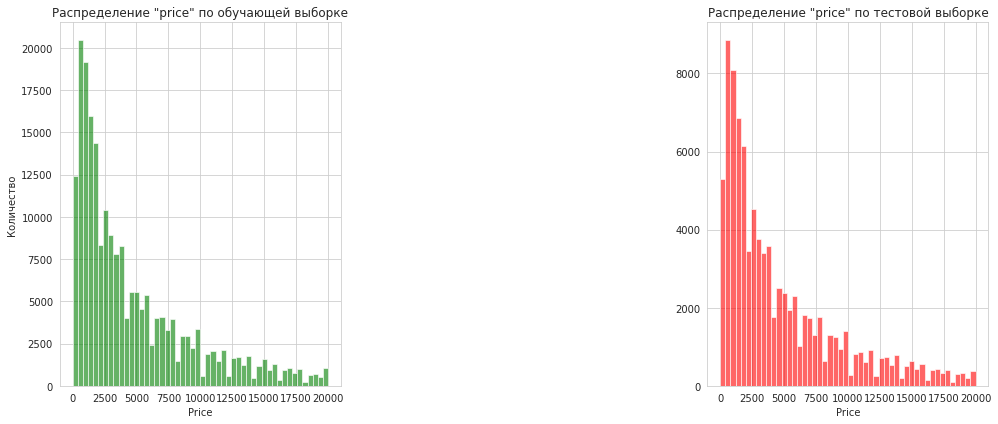

In [142]:
# Построение гистограмм для целевой переменной 'price' в каждой из выборок
plt.figure(figsize=(14, 6))

# Гистограмма для обучающей выборки
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50, color='green', alpha=0.6)
plt.title('Распределение "price" по обучающей выборке')
plt.xlabel('Price')
plt.ylabel('Количество')

# Гистограмма для тестовой выборки
plt.subplot(1, 3, 3)
plt.hist(y_test, bins=50, color='red', alpha=0.6)
plt.title('Распределение "price" по тестовой выборке')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

Распределение выглядит очень похожим друг на друга в обоих выборках.

Приступим к обучению модели LightGBM.

Выполним подготовку данных для модели.

In [149]:
# Создаём объект lgb.Dataset
# Обязательно прописываем параметр free_raw_data=False, так как мы используем "categorical_feature"
# В противном случае обучение модели выдаст ошибку
df_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

Определим функцию objective для перебора гиперпараметров с помощью и использования кросс-валидации с помощью "lgb.cv":

In [150]:
def objective(trial):
    # Гиперпараметры для настройки
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_pre_filter': False  # Для предотвращения ошибки при использовании min_child_samples
    }
    
    # Настройка ранней остановки
    early_stopping = lgb.early_stopping(stopping_rounds=50)

    # Использование lgb.cv для кросс-валидации
    cv_results = lgb.cv(param, df_train, num_boost_round=1000, nfold=5, 
                        stratified=False, shuffle=True, 
                        callbacks=[early_stopping], seed=75)

    # Минимальное значение RMSE
    return min(cv_results['rmse-mean'])

Выполним настройку для Optuna.

*Optuna - это библиотека для перебора гиперпараметров, более продвинутая, по сравнению с GridSearch, так как поддерживает раннюю остановку при достижении значимых улучшений, различные механизмы оптимизации, избавляющие от необходимости перебирать весь диапозон гиперпараметров и т.д.)*

In [151]:
# Создаём объект "испытания"
study = optuna.create_study(direction='minimize')

# Запускаем таймер
start_time = time.time()

# Устанавливаем количество "испытаний"
study.optimize(objective, n_trials=5)

# Останавливаем таймер и рассчитываем затраченное время
elapsed_time = time.time() - start_time

print(f"Подбор гиперпараметров завершён. Время выполнения: {elapsed_time:.2f} секунд.")
print('Лучшие параметры:', study.best_params)
print('Лучшее RMSE:', study.best_value),

[I 2024-05-12 15:39:02,622] A new study created in memory with name: no-name-989d2a92-0fd3-40e9-8f50-75bb47a05d92


Training until validation scores don't improve for 50 rounds


[I 2024-05-12 15:59:07,103] Trial 0 finished with value: 1782.1408314064715 and parameters: {'num_leaves': 33, 'max_depth': 3, 'learning_rate': 0.09990000631430962, 'min_child_samples': 85}. Best is trial 0 with value: 1782.1408314064715.


Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1782.14 + 22.9185
Training until validation scores don't improve for 50 rounds


[I 2024-05-12 16:03:11,704] Trial 1 finished with value: 1703.8087706086153 and parameters: {'num_leaves': 34, 'max_depth': 8, 'learning_rate': 0.14927202849403193, 'min_child_samples': 56}. Best is trial 1 with value: 1703.8087706086153.


Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1703.81 + 20.7282
Training until validation scores don't improve for 50 rounds


[I 2024-05-12 16:11:23,298] Trial 2 finished with value: 1695.2055464755467 and parameters: {'num_leaves': 57, 'max_depth': 11, 'learning_rate': 0.1260387919612222, 'min_child_samples': 40}. Best is trial 2 with value: 1695.2055464755467.


Early stopping, best iteration is:
[854]	cv_agg's rmse: 1695.21 + 20.9322
Training until validation scores don't improve for 50 rounds


[I 2024-05-12 16:45:42,707] Trial 3 finished with value: 1695.3585750587874 and parameters: {'num_leaves': 48, 'max_depth': 11, 'learning_rate': 0.11255632110337696, 'min_child_samples': 46}. Best is trial 2 with value: 1695.2055464755467.


Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1695.36 + 19.7113
Training until validation scores don't improve for 50 rounds


[I 2024-05-12 16:52:00,894] Trial 4 finished with value: 1709.4477669501218 and parameters: {'num_leaves': 61, 'max_depth': 20, 'learning_rate': 0.03407304644270171, 'min_child_samples': 90}. Best is trial 2 with value: 1695.2055464755467.


Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1709.45 + 20.2068
Обучение завершено. Время выполнения: 4378.27 секунд.
Лучшие параметры: {'num_leaves': 57, 'max_depth': 11, 'learning_rate': 0.1260387919612222, 'min_child_samples': 40}
Лучшее RMSE: 1695.2055464755467


(None,)

Результат кросс-валидации: RMSE = **1709.45**.
Лучшие гиперпараметры:
- **num_leaves**: 57,
- **max_depth**: 11, 
- **learning_rate**: 0.1260387919612222, 
- **min_child_samples**: 40

Значит, погрешность предсказания цены на текущем этапе ~ 1709 евро, что является неплохим результатом, учитывая разнообразие цен в датасете, а также условие проекта.
Совокупное время обучения с учётом каждой итерации испытания подбора гиперпараметров - **1 час 13 минут**.

После определения лучших параметров модели приступаем к обучению финальной модели, которую дальше сможем использовать на тестовой выборке.

In [154]:
# Запускаем таймер
start_time = time.time()

# Обучение финальной модели
final_params = study.best_params
final_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt'
})
final_model_lgb = lgb.train(final_params, df_train, num_boost_round=1000)

# Останавливаем таймер и рассчитываем затраченное время
elapsed_time = time.time() - start_time

print(f"Обучение завершено. Время выполнения: {elapsed_time:.2f} секунд.")

Обучение завершено. Время выполнения: 66.60 секунд.


Финальная модель LightGBM обучена.
В случае её превосходства над следующей моделью в плане качества метрики RMSE, будем тестировать её на тестовой выборке.

### Обучение модели RandomForestRegressor

Модель случайного леса не сможет обработать пропуски, в отличие от LightGBM. Поэтому нам потребуется заменить "NaN" на 0. Для этого подготовим трансформер "zero_filler" будущего пайплайна:

In [879]:
# df['power'].fillna(0, inplace=True)

In [156]:
zero_filler = SimpleImputer(strategy='constant', fill_value=0)

Далее нам нужно разделить данные на целевой признак и остальные признаки (ранее это уже было сделано в п.3.1, но для наглядной последовательности сохраним этот шаг).

In [157]:
# Сначала разделим данные на обучающий (70%) и тестовый+валидационный (30%) датасеты
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.3, random_state=75)

# Вывод размеров наборов для проверки
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 209703
Размер тестовой выборки: 89874


Вновь проверим распределение, ожидая, что оно будет похожим:

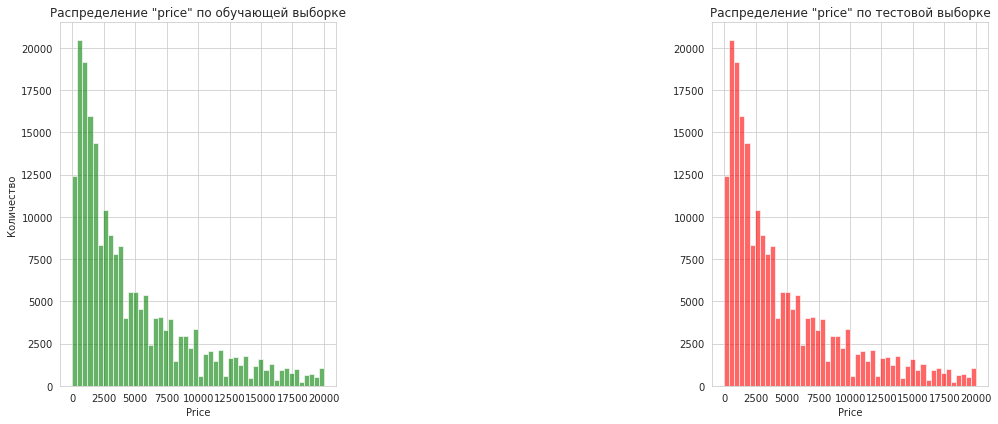

In [158]:
# Построение гистограмм для целевой переменной 'price' в каждой из выборок
plt.figure(figsize=(14, 6))

# Гистограмма для обучающей выборки
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50, color='green', alpha=0.6)
plt.title('Распределение "price" по обучающей выборке')
plt.xlabel('Price')
plt.ylabel('Количество')

# Гистограмма для тестовой выборки
plt.subplot(1, 3, 3)
plt.hist(y_train, bins=50, color='red', alpha=0.6)
plt.title('Распределение "price" по тестовой выборке')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

С распределением всё в порядке в обоих выборках.

Так как модель случайного леса не поддерживает использование текстовых категориальных признаков,, нам нужно выполнить их преобразование в числовой вид.

Признаки, которые необходимо преобразовать:
- vehicle_type;
- gearbox_type;
- model;
- driven_km;
- fuel_type;
- brand;
- repaired;
- region_code.

Взглянем на количество уникальных значений по каждому из категориальных признаков.

In [159]:
for cur in df[['vehicle_type', 'gearbox_type', 'model', 'driven_km', 'fuel_type', 'brand', 'repaired', 'region_code']].columns:
    print(cur, '-', df[cur].nunique())

vehicle_type - 8
gearbox_type - 2
model - 41
driven_km - 4
fuel_type - 2
brand - 10
repaired - 3
region_code - 16


Количество уникальных значений для каждого признака приемлемой с точки зрения того, что категорий не будет сверхмного.

Далее используем `OrdinalEncoder()` для преобразования категориальных текстовых значений в тренировочной выборе, создадим трансформер и применим его к тестовой выборке в рамках пайплайна.

Таким образом мы избежим утечки данных и сохраним корректное определение категорий.

In [160]:
# Определяем порядок для признаков driven_km и repaired
# Остальные признаки у нас лишены какой-либо иерархии
driven_km_order = ['low', 'medium', 'high', 'very_high']
repaired_order = ['no', 'yes', 'unknown']
categories_columns = [
    np.unique(X_train['vehicle_type']),
    np.unique(X_train['gearbox_type']),
    np.unique(X_train['model']),
    driven_km_order,
    np.unique(X_train['fuel_type']),
    np.unique(X_train['brand']),
    repaired_order,
    np.unique(X_train['region_code'])
]

# Создаем экземпляр OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=categories_columns)

Теперь подготовим пайплайн, обучим его на обучающей выборке и запустим на тестовой:

In [170]:
# Колонки для трансформаций
categorical_features = ['vehicle_type', 'gearbox_type', 'model', 'driven_km', 'fuel_type', 'brand', 'repaired', 'region_code']
numerical_features = ['power']

# Использование ColumnTransformer для разных типов признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', zero_filler, numerical_features),
        ('cat', ordinal_encoder, categorical_features)
    ])

# Интеграция препроцессора в пайплайн
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Обучение OrdinalEncoder на тренировочных данных и преобразование тренировочных данных
X_train = full_pipeline.fit_transform(X_train)

# Применение обученного encoder к тестовой выборке
X_test = full_pipeline.transform(X_test)

Теперь взглянем на обучающую выборку:

In [171]:
X_train

array([[ 68.,   3.,   1., ...,   2.,   1.,  14.],
       [  0.,   5.,   1., ...,   9.,   0.,   6.],
       [101.,   4.,   1., ...,   0.,   2.,   9.],
       ...,
       [163.,   1.,   0., ...,   4.,   1.,   3.],
       [ 70.,   5.,   1., ...,   6.,   0.,  10.],
       [105.,   2.,   1., ...,   1.,   0.,   3.]])

И на тестовую выборку:

In [172]:
X_test

array([[131.,   7.,   0., ...,   3.,   0.,  13.],
       [  0.,   4.,   1., ...,   6.,   0.,  11.],
       [120.,   5.,   0., ...,   6.,   0.,   7.],
       ...,
       [120.,   3.,   1., ...,   2.,   1.,   5.],
       [ 90.,   0.,   0., ...,   8.,   0.,   0.],
       [116.,   0.,   1., ...,   9.,   0.,   2.]])

Категориальные признаки преобразованы успешно. Как видно, датафреймы Pandas после преобразований в пайплайне превратились в numpy-массивы.

Для единообразия и предотвражения потенциальных пробелем из-за объектов разного типа преобразуем целевые переменные y_train и y_test в numpy-массивы. На всякий случай сохраним их в новые переменные, не перезаписывая старые:

In [174]:
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

Теперь определим функцию для подсчёта RMSE. 

In [176]:
# Определение функции RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

Создадим экземпляр модели случайного леса и настроим гиперпараметры, по которым будет идти перебор.

In [177]:
# Подготовка модели случайного леса и GridSearchCV
model = RandomForestRegressor(random_state=75)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 20]
}

Теперь запустим обучение модели с кросс-валидацией.

In [180]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=rmse_scorer)

# Запускаем таймер
start_time = time.time()

grid_search.fit(X_train, y_train_array)

# Останавливаем таймер и рассчитываем затраченное время
elapsed_time = time.time() - start_time

print(f"Обучение модели завершено. Время выполнения: {elapsed_time:.2f} секунд.")

Обучение модели завершено. Время выполнения: 4117.01 секунд.


Модель обучена, кросс-валидация выполнена.
Время выполнения: **1 час 8 минут**.

Проверим результаты качества метрики RMSE и лучших параметров.

In [181]:
# Вывод лучших параметров и RMSE
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее RMSE:", -grid_search.best_score_)

Лучшие параметры: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Лучшее RMSE: 2499.151588836772


По результатам получилось, что наилучший набор гиперпараметров из изменяемых нами следующий:
- max_depth: 20;
- min_samples_split: 10;
- n_estimators: 200.

Значение метрики RMSE при этом - 2499.15. Получается, что модель случайного леса в текущей конфигурации предсказывает цену автомобиля с погрешностью ~2499 евро.

## Анализ моделей и тестирование.

### Анализ моделей

Мы обучили две модели:
- **LightGBM**;
- **RandomForestRegressor**.

Обе модели показали сопоставимый результат:
- **LightGBM**: RMSE ~ 1709; (лучший результат)
- **RandomForestRegressor** ~ 2499.

Что касается времени кросс-валидации (обучение/предсказание), то оно сильно зависит от настроек, которые мы применяем. В данном случае результаты приблизительно следующие:
- **LightGBM**: 1 час 13 минут на подбор гиперпараметров и кросс-валидацию + 1 минута на обучение финальной модели LightGBM; (лучший результат)
- **RandomForestRegressor** 1 час 8 минут.

Скорость обучения можно повысить, снизив диапозон гиперпараметров и число "испытаний" (для LightGBM). Также, производительность может зависеть от технических характеристик устройства, на котором выполняются вычисления.

Учитывая результаты выше, наиболее оптимальной для нашей задачи выглядит использование модели **LightGBM**. Время, затраченное на подбор гиперпараметров и обучение не отличается существенно, зато метрика RMSE выше у LightGBM. Её мы и используем на тестовой выборке.

### Тестирование модели

Для тестирования мы выбрали модель LightGBM как модель, показавшую наилучшие результаты в ходе работы по п.3 по показателю качества метрики RMSE и времени обучения.

Сформируем заново разделение выборок, т.к. мы перезаписали переменные в п.3.2.

In [183]:
# Сначала разделим данные на обучающий (70%) и тестовый+валидационный (30%) датасеты
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.3, random_state=75)

In [184]:
# Запускаем таймер
start_time = time.time()

# Делаем предсказания на тестовой выборке
y_pred = final_model_lgb.predict(X_test)

# Останавливаем таймер и рассчитываем затраченное время
elapsed_time = time.time() - start_time

# Вычисляем RMSE на тестовой выборке
test_rmse = mean_squared_error(y_test_array, y_pred, squared=False)

print(f"Предсказание цены завершено. Время выполнения: {elapsed_time:.2f} секунд.")
print("Результат RMSE: ", test_rmse)

Предсказание цены завершено. Время выполнения: 12.69 секунд.
Результат RMSE:  1691.3953259426535


### Выводы

Итоговый результат работы модели LightGBM на тестовой выборке - **1691.39**. Результат даже немного лучше, чем при кросс-валидации.

Время предсказания на тестовой выборке: 12,6 секунд.

По требованиям проекта значение метрики RMSE должно быть менее, чем 2500, что нам удалось выполнить. Можно считать обученную модель успешной.

## Выводы

В ходе работы над проектом были выполнены следующие шаги:

1. Выполнена установка и импорт необходимых библиотек и функций для работы над проектом;
2. Был выполнен первоначальный обзор датасета, в ходе которого мы: 
    - ознакомились со структурой датасета;
    - ознакомились с данными таблицы и определили первые и наиболее очевидные места, требующие анализа и предобработки;
    - определили тип задачи как **задачу регрессии**, учитывая, что целевым признаком является цена автомобиля.
3. Выполнили масштабную предобработку данных:
    - Переименовали столбцы, приведя их к более унифицированному, однозначно читаемому виду;
    - Проанализировали датасет на наличие лишних признаков и удалили часть из них;
    - Различными средствами устранили дубликаты, выбросы и иные аномалии в данных;
    - Создали два новых признака для улучшения качества обучения модели: "car_age_years" (возраст автомобиля) и "region_code" (код региона). Создание признаков было выполнено как на основе уже имеющихся данных в датасете, так и с помощью внешних данных из иных источников;
4. Выполнили настройку и обучение двух моделей машинного обучения, подобрав оптимальные гиперпараметры:
    - Модель градиентного бустинга "LightGBM";
    - Модель случайного леса.
5. Сравнили результаты обучения и работы моделей на этапе кросс-валидации и выбрали наиболее успешную модель - **LightGMB**.
6. Протестировали выбранную модель на тестовой выборке и получили результат метрики RMSE - 1691 при времени предсказания 12 секунд. Результат удовлетворяет требованию того, чтобы его значение было меньше 2500. Следует также иметь ввиду, что подбор оптимальных гиперпараметров модели может занимать больше 1 часа.

Подробное описание шагов можно посмотреть в остальной части проекта.

**Выводы и рекомендации**:

В ходе работы было выявлено множество проблем, связанных с качеством данных. В ходе предобработки данных вынужденно избавились от 15% данных с учётом того, что удаление данных (особенно больших объёмов) использовалось как крайняя мера, когда не было возможности исправить данные, не навредив дальнейшему процессу обучения моделей.

***Основные выявленные проблемы***:
- Признак **"pictures_count"** для каждого объявления содержал значение "0", что, вероятно, является некорректным значением. Наличие или отсутствие изображений автомобиля потенциально могло бы влиять на цену автомобиля в объявлении;
- В поле **"registration_month"** была несогласованность формата записи месяца. Два возможных формата: "от 0 до 11" или "от 1 до 12". В датасете была представлена смешанная форма "от 0 до 12", что добавило 13-й месяц;
- В поле **"registration_year"** было представлено множество аномальных годов выпуска автомобиля: как далёкое прошлое, так и далёкое будущее;
- Дата выпуска как таковая (комбинация **registration_month** и **registration_year**) в некоторых случаях противоречила данным столбца **"date_created"**. Выглядело так, будто автомобиль был выпущен после того, как появилось объявление в сервисе, что является явной ошибкой;
- В датасете представлено большое количество аномально низких цен на автомобиль (0 евро, 1 евро, 100 евро и т.д.);
- Столбец **"model"** содержал неявные дубли;
- Столбец **"vehicle_type"** содержал большое количество пропусков (11% от общего числа объектов). Данные пропуски были заполнены на основе "моды" значений в рамках групп брендов и моделей. Заполнение пропусков получилось в некоторой степени грубым, но потеря 11% записей достаточно была бы менее желательным вариантом для нашей задачи. Кроме того, признак кажется достаточно важным в вопросе ценообразования;
- Столбцы **"gearbox_type"** и **"fuel_type"** имеют аналогичную проблему, как **"vehicle_type"**;
- Столбец **"power"** имеет почти 10% записей с нулевым значением, а также большое количество аномально низкий и аномально высоких значений. Все эти значения также были предобработаны без удаления записей;
- В датасете было достаточно существенное количество полных дублей.

Для устранения большинства указанных проблем рекомендуем рассмотреть возможность настройки форм ввода пользователей таким образом, чтобы ввод значений в те или иные поля был обязательным и ограничивался заранее предусмотренными словарями (таким образом, получится устранить проблему неявных дублей или некорректных годов).

Также, может помочь дополнительный контроль количественных признаков, чтобы предотвратить наличие в базе данных столбцов с явно аномальными значениями.

В случае повышения качества данных датасета снизятся трудозатраты на будущие работы по анализу и обучению моделей, а также, может повыситься качество предсказаний целевого признака.